# **Programming Assignment 7 in the ML & AI Fundamentals Module**

> **Note:** Please ensure that PyTorch is properly installed on your device before starting.

In [90]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [91]:
# Import util functions
from utils_v2 import make_spiral 
from utils_v2 import plot_data, plot_data_and_decision_boundary, draw_mlp_network, plot_training_progress, plot_decision_boundary_roundwise

### **Generate the Dataset**

In this section, we will generate a synthetic spiral dataset, which is commonly used to test the classification capabilities of neural networks. The spiral dataset is challenging due to its non-linear and intertwined class structure, making it ideal for evaluating the performance of different model architectures.

- **Step 1:** Generate the data using the provided utility function.
- **Step 2:** Visualize the dataset to understand its structure.

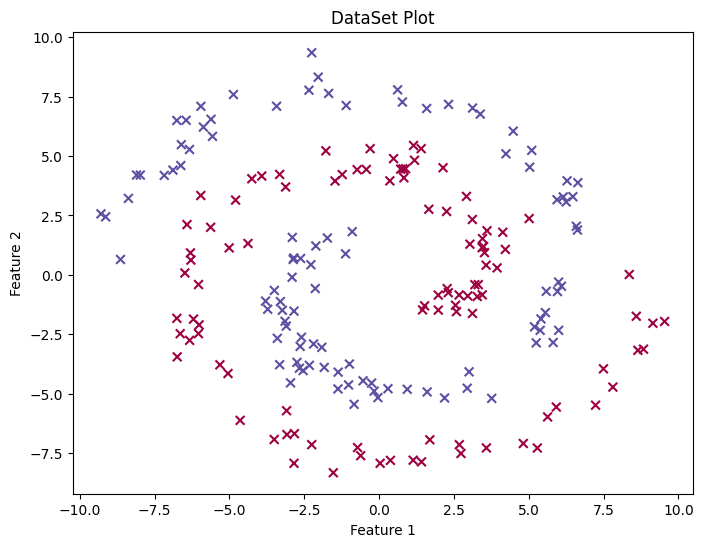

In [92]:
# Generate and plot the dataset
X, y = make_spiral(n_samples=100)
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)
plot_data(X, y)

### **Setting Up PyTorch**

<div class="alert alert-block alert-success">
<b>Tip:</b> Selecting the right hardware (CPU, GPU, or accelerator) can significantly speed up training and improve model performance.  
Check your device and make sure PyTorch is using the best available resource!
</div>

In [93]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using mps device


# **Q1:**
*Implement and train a neural network on the dataset generated above. You are free to use any network architecture you think is useful. Finally, plot the decision boundary generated by your model.*

<div class="alert alert-block alert-info">

**Workflow of Training a Neural Network:**

1. **Parameter Initialization:**  
    Weights and biases (`W[1]`, `b[1]`, `W[2]`, `b[2]`, ...) are set randomly.

2. **Forward Pass:**  
    Input data is passed through the network to compute activations (predictions).

3. **Loss Calculation:**  
    The error between predictions and true labels is determined using a loss function.

4. **Backpropagation:**  
    Errors are propagated backward through the network to compute gradients of the parameters.

5. **Weight Update:**  
    Parameters are updated using an optimization rule (e.g., gradient descent).

> **Note:**  
> Steps 2 to 5 are repeated until the network performs satisfactorily or a predefined number of iterations is reached.

</div>

### **Use of PyTorch Dataset and DataLoader for Better Performance**

**Dataset Class:**
- The `Dataset` class serves as a container to wrap your data in a way that PyTorch can efficiently process.
- A custom dataset class like `SpiralDataset` typically inherits from `torch.utils.data.Dataset`, which is an abstract base class requiring the implementation of two methods: `__len__()` and `__getitem__()`.
- The `__init__()` method is used to load and store the data (features `X` and labels `y`), converting them to PyTorch tensors—an essential step to make them compatible with PyTorch operations.
- The `__len__()` method returns the total number of data points in the dataset.
- The `__getitem__()` method returns a single data point, consisting of a feature vector and its corresponding label, based on a given index.

**DataLoader:**
- The `DataLoader` is responsible for loading data in batches and optionally shuffling it at the start of each epoch.
- PyTorch’s `DataLoader` automates and optimizes the process of batching and feeding data into the model during training, which can significantly speed up training and reduce memory overhead.
- For example, `DataLoader(dataset, batch_size=32, shuffle=True)` creates a loader that fetches data in batches of 32 and shuffles the order of samples before each training epoch.


In [94]:
# Define Dataset and DataLoader
class SpiralDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

dataset = SpiralDataset(X, y)
dataloader = DataLoader(dataset, batch_size=300, shuffle=True) # Bacht size of 1 -> Stochastic Gradient Descent (SGD)

### **Design the Model and intialize the Parameters**

1. **Parameter Initialization:**  
    The network weights are initialized using a normal distribution centered at 0.

2. **PyTorch Model Initialization Methods:**  
    PyTorch offers two main approaches to define neural networks:
    - **Manual Definition:**  
      Create a custom class inheriting from `nn.Module` and explicitly define the `forward()` method.
    - **Sequential API:**  
      Use `nn.Sequential` to stack layers in order, creating a simple pipeline without needing a custom `forward()` method.  
      Example:
      ```python
      model = nn.Sequential(
            nn.Linear(2, 10),
            nn.ReLU(),
            nn.Linear(10, 2),
            nn.Softmax(dim=1)
      )
      ```

In [95]:
# Define the Neural Network Architecture
class First_NeuralNetwork(nn.Module):
    def __init__(self):
        super(First_NeuralNetwork, self).__init__()
        self.hidden_layer_1 = nn.Linear(2, 10)
        self.hidden_layer_2 = nn.Linear(10, 10)
        self.output_layer = nn.Linear(10, 2)
        self.softmax = nn.Softmax(dim=1)
        self.relu = nn.ReLU()

        # Initialize weights with normal distribution
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0.0, std=0.1)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        x = self.relu(self.hidden_layer_1(x))
        x = self.relu(self.hidden_layer_2(x))
        x = self.softmax(self.output_layer(x))
        return x

In [96]:
# Instantiate the model
first_model = First_NeuralNetwork()

### **Take a look at the model**
This section provides an overview of the initialized neural network model, allowing to inspect its architecture and parameters before proceeding with training.

In [97]:
# Show the network parameters
for name, param in first_model.named_parameters():
    print(f"\n parameters for {name}:\n", param.data)


 parameters for hidden_layer_1.weight:
 tensor([[-0.0176, -0.0345],
        [-0.2113, -0.0518],
        [-0.0037,  0.0926],
        [ 0.0159, -0.1325],
        [ 0.0747,  0.0909],
        [ 0.1607, -0.1580],
        [-0.1920,  0.0616],
        [ 0.0629, -0.0068],
        [ 0.0880, -0.1696],
        [ 0.1031, -0.1025]])

 parameters for hidden_layer_1.bias:
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

 parameters for hidden_layer_2.weight:
 tensor([[ 0.0400, -0.0556,  0.1215, -0.0326, -0.0694, -0.2026, -0.0369, -0.0831,
          0.0662, -0.3459],
        [ 0.0587,  0.1182,  0.0527,  0.0308, -0.0536,  0.0588,  0.0120, -0.0579,
          0.1450, -0.0152],
        [ 0.0796, -0.0960,  0.0081,  0.0060, -0.0420,  0.0306, -0.0590,  0.0423,
         -0.1912, -0.0114],
        [ 0.0015, -0.0562, -0.0370,  0.0507, -0.0788, -0.0626,  0.1040,  0.1316,
          0.0951,  0.0474],
        [-0.1101,  0.0010, -0.0443,  0.0956,  0.0310,  0.1359,  0.0981,  0.0653,
          0.0342, -0.0445],
    

### **Perform a singel forward Pass:**

During the forward pass, the neural network processes the input data sequentially through each layer, applying learned weights and activation functions to transform the input into an output prediction. This step is essential for evaluating how well the current model parameters perform on the given data, and it forms the basis for calculating the loss, which guides subsequent learning steps.


In [98]:
# Perfrom one forward pass to check the model:
with torch.no_grad():
    sample_input = torch.tensor(X[:5], dtype=torch.float32)
    sample_output = first_model(sample_input)
    labels = torch.argmax(sample_output, dim=1)
    #criterion_output = criterion(sample_output, torch.tensor([0], dtype=torch.long))
    print(f"Sample input:\n{sample_input} \n \n Sample output:\n {sample_output}\n \n Resulting Label:  {labels}" )#, Loss: {criterion_output.item()}")

Sample input:
tensor([[-1.7769,  5.2217],
        [ 8.6473, -3.1784],
        [-2.2482, -7.1489],
        [-6.6416, -2.4775],
        [ 4.2191,  1.0704]]) 
 
 Sample output:
 tensor([[0.4802, 0.5198],
        [0.4536, 0.5464],
        [0.4771, 0.5229],
        [0.4890, 0.5110],
        [0.4895, 0.5105]])
 
 Resulting Label:  tensor([1, 1, 1, 1, 1])


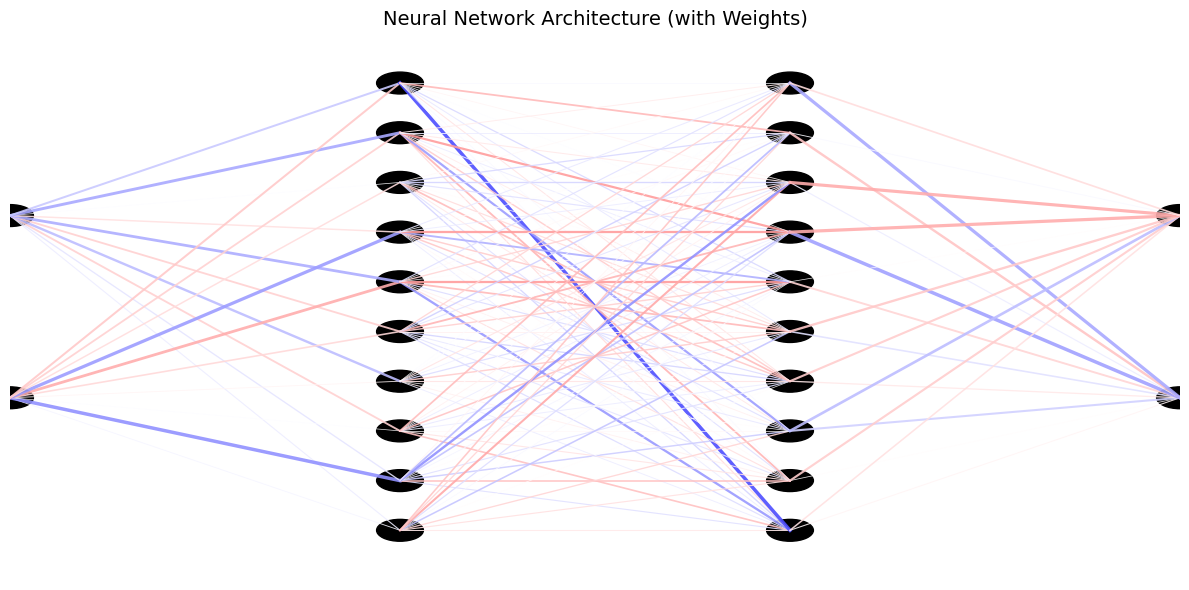

In [99]:
draw_mlp_network(first_model, show_weights=True)

<Axes: title={'center': 'Decision Boundary'}, xlabel='Feature 1', ylabel='Feature 2'>

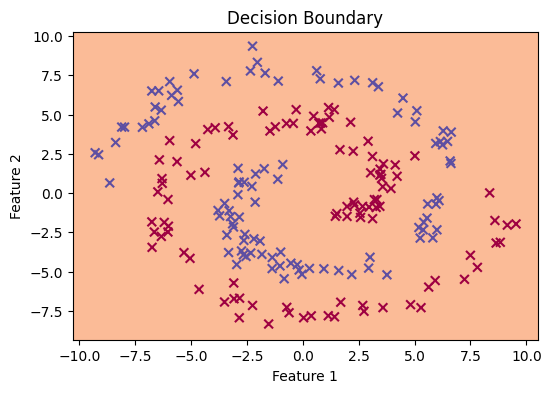

In [100]:
plot_data_and_decision_boundary(first_model, X, y)

### **Perform Backpropagation**

Backpropagation is the core algorithm for training neural networks. It efficiently computes the gradients of the loss function with respect to each model parameter by propagating errors backward through the network. This process enables the optimizer to update the weights in a direction that minimizes the loss, allowing the model to learn from data. Backpropagation leverages the chain rule from calculus to handle complex, multi-layer architectures, making deep learning feasible and scalable.

Output logits:
 tensor([[0.4835, 0.5165],
        [0.4836, 0.5164],
        [0.4935, 0.5065],
        [0.4738, 0.5262],
        [0.4640, 0.5360],
        [0.4875, 0.5125],
        [0.4874, 0.5126],
        [0.4939, 0.5061],
        [0.4921, 0.5079],
        [0.4805, 0.5195],
        [0.4873, 0.5127],
        [0.4921, 0.5079],
        [0.4918, 0.5082],
        [0.4707, 0.5293],
        [0.4767, 0.5233],
        [0.4890, 0.5110],
        [0.4904, 0.5096],
        [0.4893, 0.5107],
        [0.4891, 0.5109],
        [0.4806, 0.5194],
        [0.4678, 0.5322],
        [0.4916, 0.5084],
        [0.4889, 0.5111],
        [0.4936, 0.5064],
        [0.4754, 0.5246],
        [0.4810, 0.5190],
        [0.4637, 0.5363],
        [0.4736, 0.5264],
        [0.4510, 0.5490],
        [0.4802, 0.5198],
        [0.4942, 0.5058],
        [0.4693, 0.5307],
        [0.4860, 0.5140],
        [0.4932, 0.5068],
        [0.4717, 0.5283],
        [0.4929, 0.5071],
        [0.4811, 0.5189],
        [0.4671, 0.532

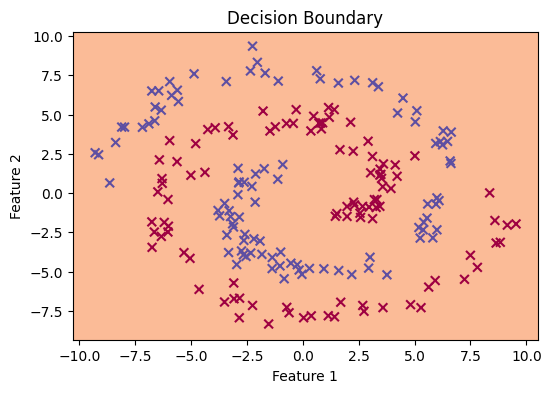

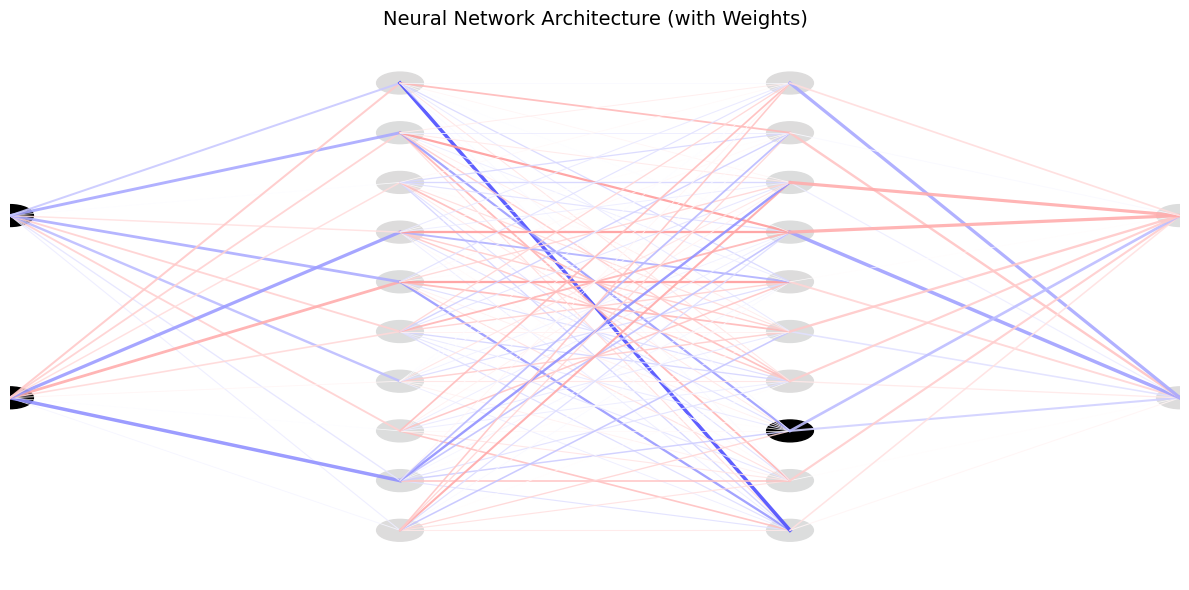

In [101]:
batch_X, batch_y = next(iter(dataloader))

# Perform a single forward pass
output_logits = first_model(batch_X)
print("Output logits:\n", output_logits)

# Calculate the loss
criterion = nn.CrossEntropyLoss()
loss = criterion(output_logits, batch_y)
print("\nLoss:\n", loss.item())

# Compute gradients (backward pass)
first_model.zero_grad()  # Clear previous gradients
loss.backward()    # Compute gradients

# Display gradients for each layer
for name, param in first_model.named_parameters():
    if param.requires_grad:
        print(f"\nGradients for {name}:\n", param.grad)

# Update Weights
# Normally done by optimizer, here for visualization only

learning_rate = 0.01
with torch.no_grad():
    for param in first_model.parameters():
        param -= learning_rate * param.grad

# Show updated parameters
for name, param in first_model.named_parameters():
    print(f"\nUpdated parameters for {name}:\n", param.data)

plot_data_and_decision_boundary(first_model, X, y)
draw_mlp_network(first_model, show_weights=True)

### **Iterate the Training-processes**

In this section, we will implement a training loop for our neural network. This function will handle the iterative process of feeding data through the model, computing the loss, performing backpropagation, and updating the model parameters over multiple epochs. Additionally, it will visualize the training progress and decision boundaries at regular intervals to help us monitor the learning process.

In [102]:
# Funktion to perform the training of the model
def train_model(model, learning_rate=0.01, optimizer_fn=optim.Adam, loss_fn=nn.CrossEntropyLoss, num_epochs=100, plot_interval=10):
    criterion = loss_fn()
    optimizer = optimizer_fn(model.parameters(), lr=learning_rate)

    train_loss = []
    train_acc = []

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        correct = 0

        for batch_X, batch_y in dataloader:
            y_pred = model(batch_X)
            loss = criterion(y_pred, batch_y)
            epoch_loss += loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            with torch.no_grad():
                predictions = torch.argmax(y_pred, dim=1)
                correct += (predictions == batch_y).sum().item()

        train_loss.append(epoch_loss / len(dataloader))
        accuracy = correct / len(dataset)
        train_acc.append(accuracy * 100)

        if (epoch + 1) % plot_interval == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss[-1]:.4f}, Accuracy: {train_acc[-1]:.2f}%")
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
            plot_decision_boundary_roundwise(model, X_tensor, y_tensor, ax=ax1)
            ax1.set_title(f"Decision Boundary (Epoch {epoch+1})")
            draw_mlp_network(model, show_weights=True, ax=ax2)
            plt.tight_layout()
            plt.show()

    # Plot final metrics with dual axes (optional, falls du auch das entfernen willst, kannst du diesen Block löschen)
    fig, ax1 = plt.subplots(figsize=(8, 6))
    color = 'tab:blue'
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Train Loss', color=color)
    ax1.plot(train_loss, color=color, label='Train Loss')
    ax1.tick_params(axis='y', labelcolor=color)
    ax2 = ax1.twinx()
    color = 'tab:red'
    ax2.set_ylabel('Train Accuracy (%)', color=color)
    ax2.plot(train_acc, color=color, label='Train Accuracy')
    ax2.tick_params(axis='y', labelcolor=color)
    fig.suptitle('Training Loss and Accuracy')
    fig.tight_layout()
    plt.show()

    return model


Epoch [100/1000], Loss: 0.6527, Accuracy: 62.00%


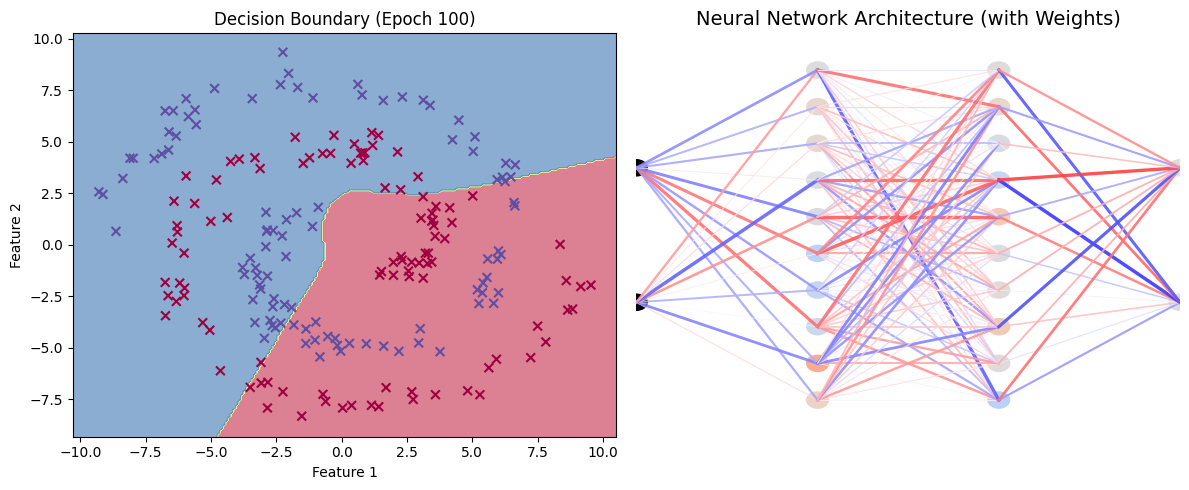

<Figure size 640x480 with 0 Axes>

Epoch [200/1000], Loss: 0.5725, Accuracy: 80.00%


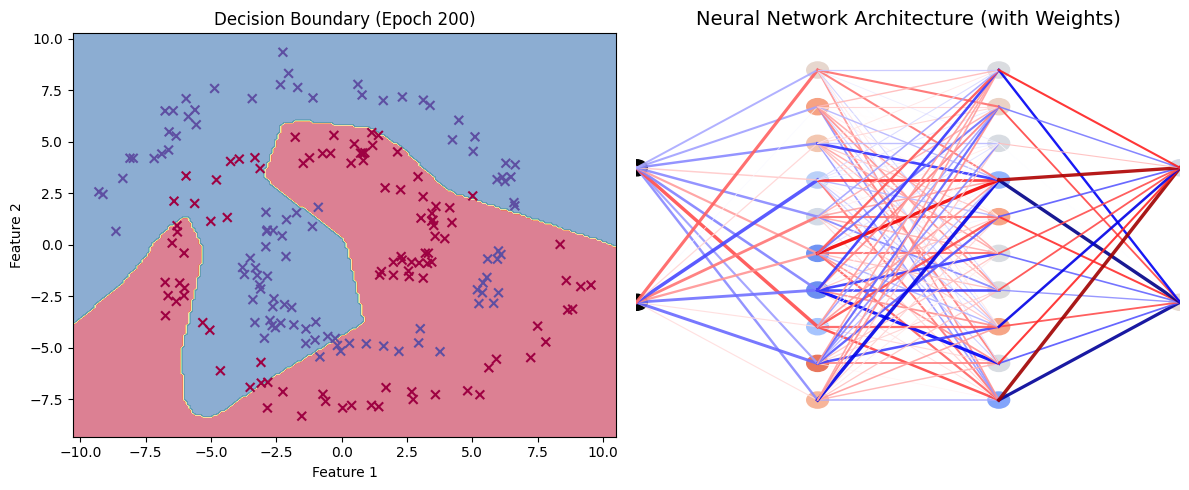

<Figure size 640x480 with 0 Axes>

Epoch [300/1000], Loss: 0.4480, Accuracy: 91.50%


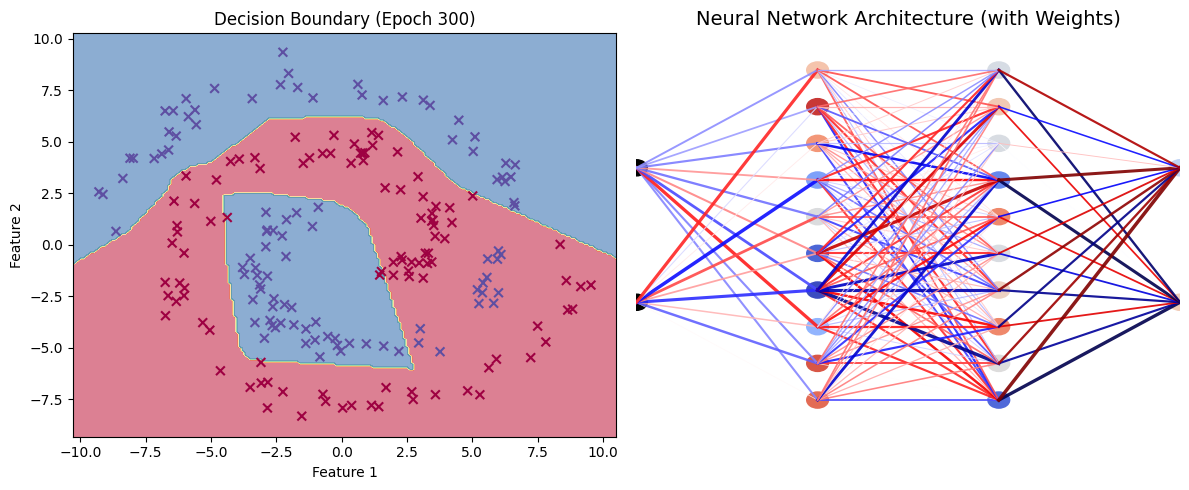

<Figure size 640x480 with 0 Axes>

Epoch [400/1000], Loss: 0.4135, Accuracy: 93.00%


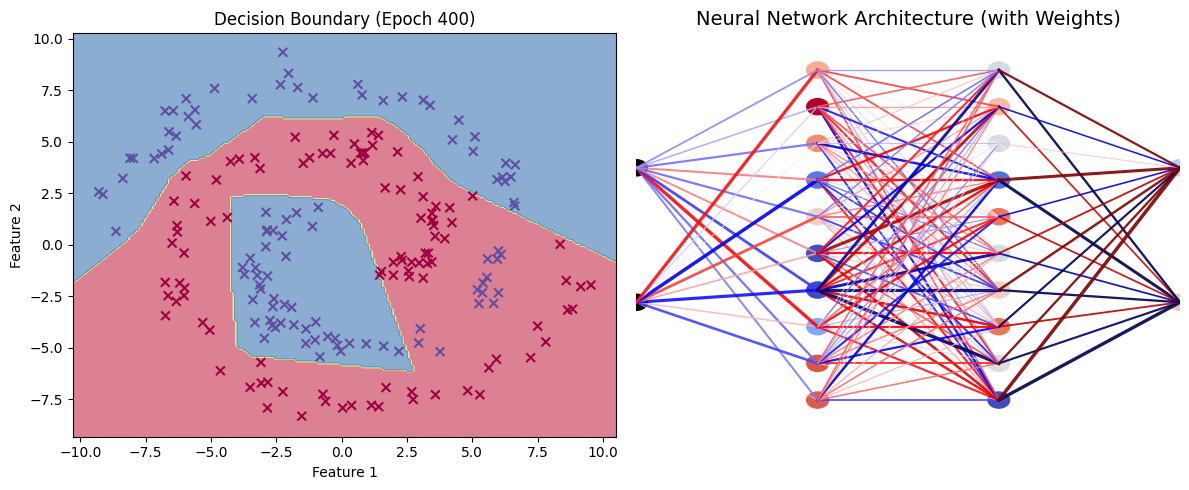

<Figure size 640x480 with 0 Axes>

Epoch [500/1000], Loss: 0.3898, Accuracy: 93.00%


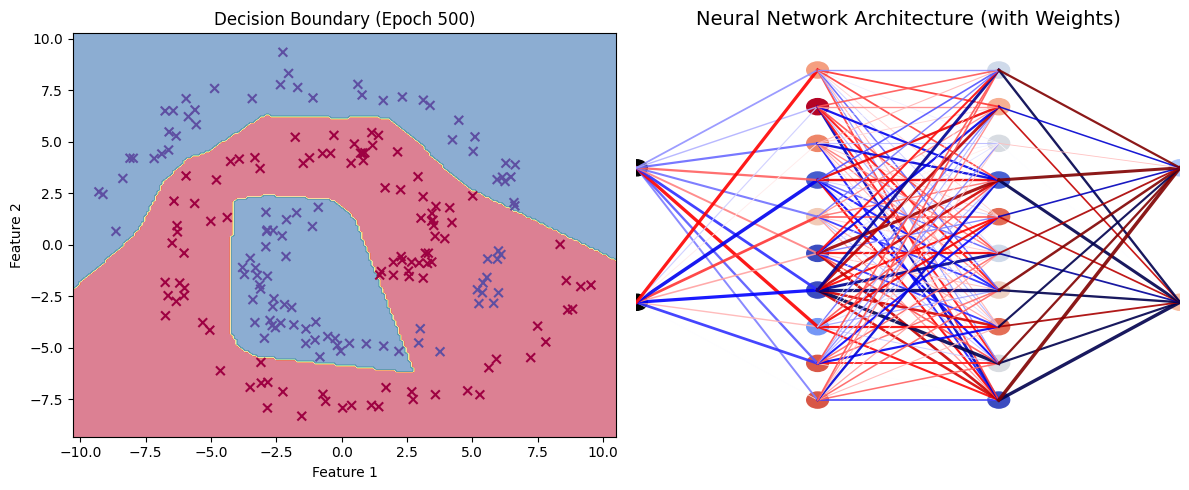

<Figure size 640x480 with 0 Axes>

Epoch [600/1000], Loss: 0.3980, Accuracy: 93.00%


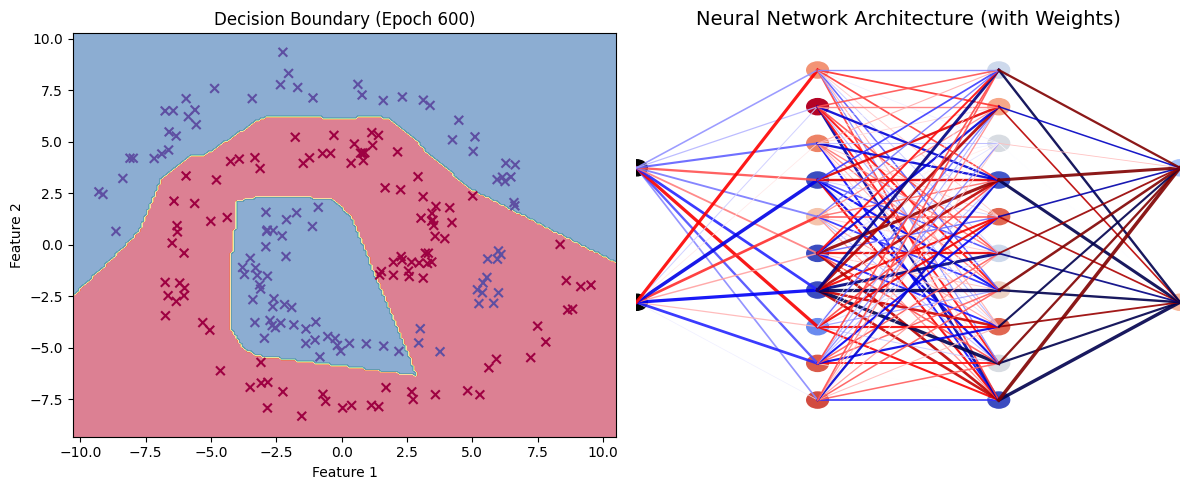

<Figure size 640x480 with 0 Axes>

Epoch [700/1000], Loss: 0.3818, Accuracy: 93.00%


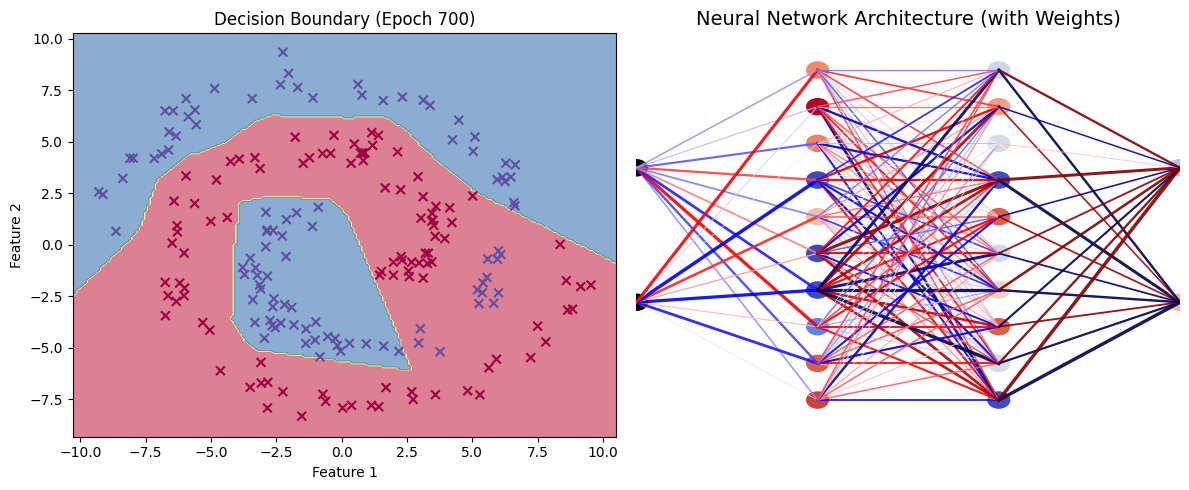

<Figure size 640x480 with 0 Axes>

Epoch [800/1000], Loss: 0.3831, Accuracy: 93.00%


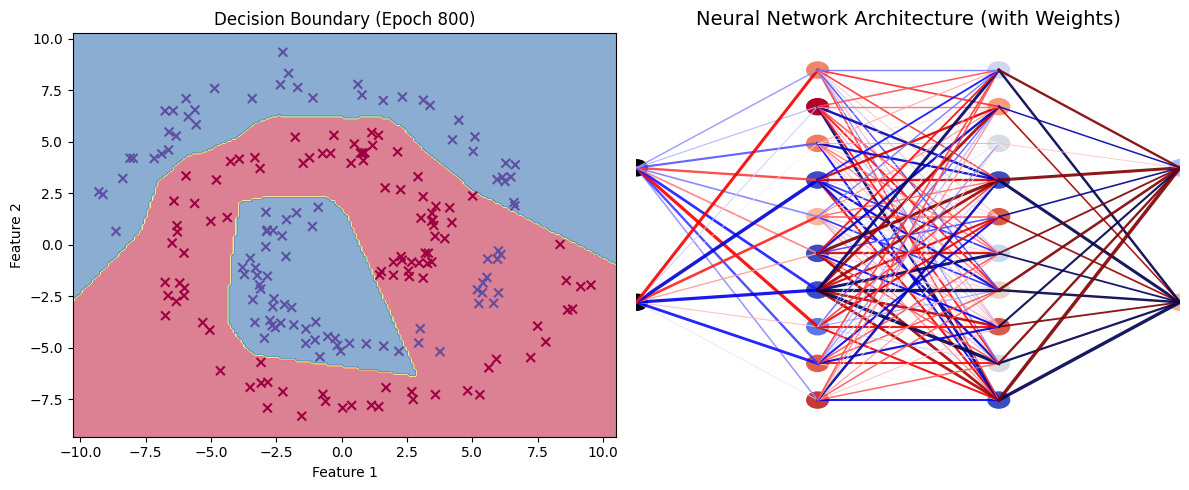

<Figure size 640x480 with 0 Axes>

Epoch [900/1000], Loss: 0.3791, Accuracy: 93.00%


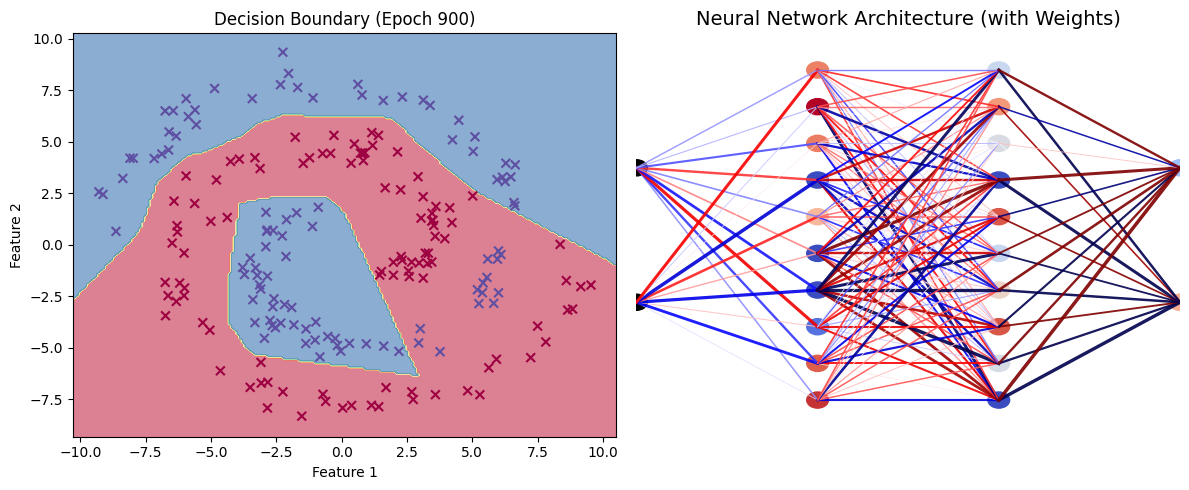

<Figure size 640x480 with 0 Axes>

Epoch [1000/1000], Loss: 0.3783, Accuracy: 93.00%


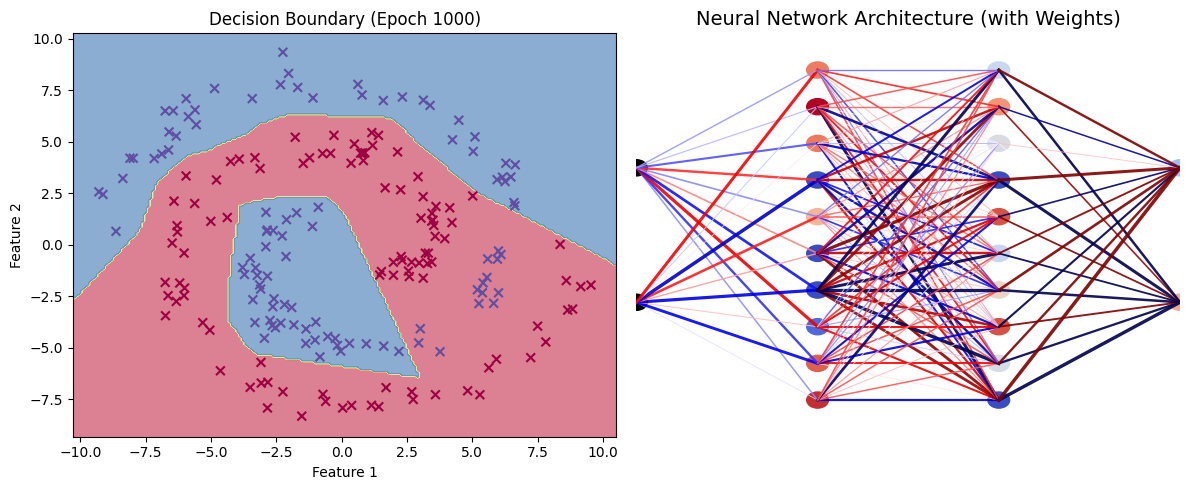

<Figure size 640x480 with 0 Axes>

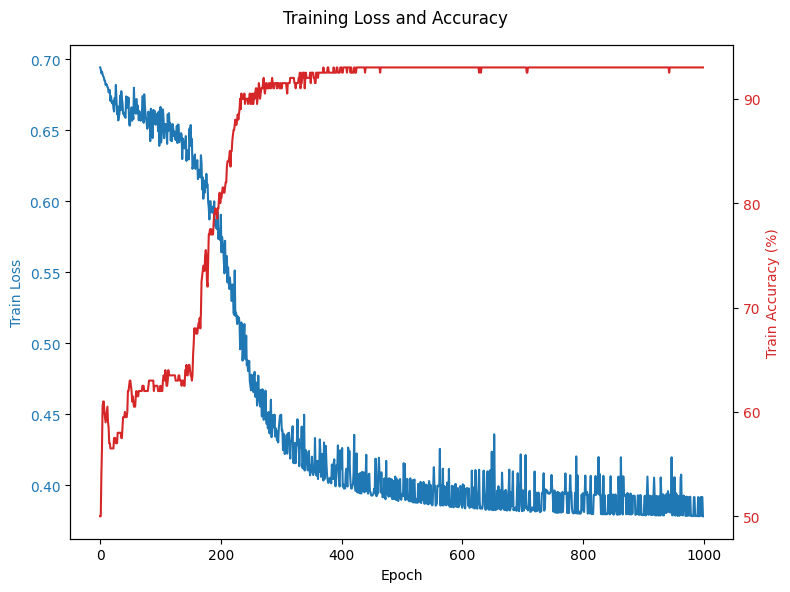

In [103]:
# Example for training the model with parameterized inputs
dataloader = DataLoader(dataset, batch_size=32, shuffle=True) # Bacht size of 1 -> Stochastic Gradient Descent (SGD)

model = train_model(first_model, learning_rate=0.001, optimizer_fn=optim.Adam, loss_fn=nn.CrossEntropyLoss, num_epochs=1000, plot_interval=100)

<Axes: title={'center': 'Decision Boundary'}, xlabel='Feature 1', ylabel='Feature 2'>

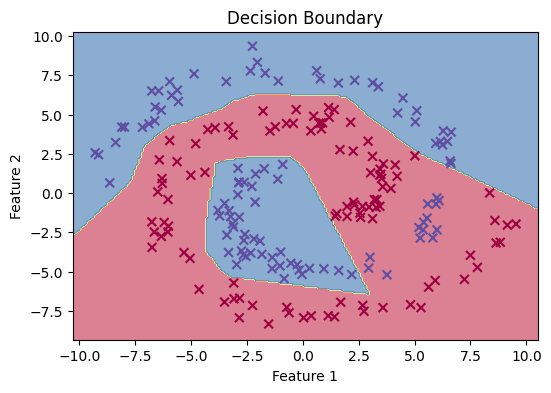

In [104]:
plot_data_and_decision_boundary(model, X, y)

# **Q2**
*Play around with the hyperparameters of your network (# hidden layers, # neurons, loss func-
tion, etc.) and see how this influences the decision boundary. Can you find a network archi-
tecture that classifies all training records correctly?*

#### *Helper Functions*
To streamline experimentation, we will implement a flexible approach for defining and training neural network models. This allows us to easily adjust architectures, activation functions, optimizers, and other hyperparameters for comparison and analysis.

In [105]:
from utils_v2 import FlexibleNeuralNetwork, train_flexible_model, compare_parameter_group, visualize_results

### **Defining different Models**

architectures = [
    {  
        'name': 'Flaches Netz [10]',
        'model_params': {
            'input_dim': 2,
            'hidden_layers': [10],
            'output_dim': 2,
            'activation': nn.ReLU()
        }
    }
]

activation_functions = [
    {
        'name': 'ReLU',
        'model_params': {
            'input_dim': 2,
            'hidden_layers': [10, 10],
            'output_dim': 2,
            'activation': nn.ReLU()
        }
    }
]

loss_functions = [
    {
        'name': 'CrossEntropy',
        'training_params': {
            'loss_fn': nn.CrossEntropyLoss,
            'optimizer_fn': optim.Adam,
            'learning_rate': 0.01,
            'batch_size': 32,
            'num_epochs': 200
        }
    }
]


### **About the Different Models**

In this section, we explore how varying neural network architectures and hyperparameters affect the model's ability to classify the challenging spiral dataset. By systematically adjusting the number of hidden layers, neurons per layer, activation functions, optimizers, loss functions, and batch sizes, we can observe their impact on learning dynamics and decision boundaries.

- **Architectures:**  
    We compare shallow, standard, deep, and wide networks to see how model depth and width influence performance and capacity to capture complex patterns.

- **Activation Functions:**  
    Different activation functions (ReLU, Sigmoid, Tanh, LeakyReLU) are tested to understand their effect on non-linearity, convergence speed, and gradient flow.

- **Optimizers & Learning Rates:**  
    Various optimizers (Adam, SGD, RMSprop) and learning rates are evaluated to find the best combination for stable and efficient training.

- **Loss Functions:**  
    Both CrossEntropy and MSE losses are considered to analyze their suitability for classification tasks.

- **Batch Sizes:**  
    The influence of batch size on training stability and generalization is examined by experimenting with small, medium, and full-batch settings.

By visualizing the results for each configuration, we gain insights into which model designs are most effective for this non-linear classification problem and how hyperparameter choices shape the learned decision boundaries.

In [106]:
# Define various model architectures
architectures = [
    {
        'name': 'Shallow [10]',
        'model_params': {
            'input_dim': 2,
            'hidden_layers': [10],
            'output_dim': 2,
            'activation': nn.ReLU()
        }
    },
    {
        'name': 'Standard [10, 10]',
        'model_params': {
            'input_dim': 2,
            'hidden_layers': [10, 10],
            'output_dim': 2,
            'activation': nn.ReLU()
        }
    },
    {
        'name': 'Deep [10, 10, 10]',
        'model_params': {
            'input_dim': 2,
            'hidden_layers': [10, 10, 10],
            'output_dim': 2,
            'activation': nn.ReLU()
        }
    },
    {
        'name': 'Wide [20, 20]',
        'model_params': {
            'input_dim': 2,
            'hidden_layers': [20, 20],
            'output_dim': 2,
            'activation': nn.ReLU()
        }
    }
]

# Define different activation functions
activation_functions = [
    {
        'name': 'ReLU',
        'model_params': {
            'input_dim': 2,
            'hidden_layers': [10, 10],
            'output_dim': 2,
            'activation': nn.ReLU()
        }
    },
    {
        'name': 'Sigmoid',
        'model_params': {
            'input_dim': 2,
            'hidden_layers': [10, 10],
            'output_dim': 2,
            'activation': nn.Sigmoid()
        }
    },
    {
        'name': 'Tanh',
        'model_params': {
            'input_dim': 2,
            'hidden_layers': [10, 10],
            'output_dim': 2,
            'activation': nn.Tanh()
        }
    },
    {
        'name': 'LeakyReLU',
        'model_params': {
            'input_dim': 2,
            'hidden_layers': [10, 10],
            'output_dim': 2,
            'activation': nn.LeakyReLU(0.1)
        }
    }
]

# Define various optimizers and learning rates
optimizers = [
    {
        'name': 'Adam LR=0.01',
        'training_params': {
            'optimizer_fn': optim.Adam,
            'learning_rate': 0.01,
            'batch_size': 32,
            'num_epochs': 200
        }
    },
    {
        'name': 'SGD LR=0.01',
        'training_params': {
            'optimizer_fn': optim.SGD,
            'learning_rate': 0.01,
            'batch_size': 32,
            'num_epochs': 200
        }
    },
    {
        'name': 'RMSprop LR=0.01',
        'training_params': {
            'optimizer_fn': optim.RMSprop,
            'learning_rate': 0.01,
            'batch_size': 32,
            'num_epochs': 200
        }
    },
    {
        'name': 'Adam LR=0.001',
        'training_params': {
            'optimizer_fn': optim.Adam,
            'learning_rate': 0.001,
            'batch_size': 32,
            'num_epochs': 200
        }
    }
]

# Define different loss functions
loss_functions = [
    {
        'name': 'CrossEntropy',
        'training_params': {
            'loss_fn': nn.CrossEntropyLoss,
            'optimizer_fn': optim.Adam,
            'learning_rate': 0.01,
            'batch_size': 32,
            'num_epochs': 200
        }
    },
    {
        'name': 'MSE',
        'training_params': {
            'loss_fn': nn.MSELoss,
            'optimizer_fn': optim.Adam,
            'learning_rate': 0.01,
            'batch_size': 32,
            'num_epochs': 200
        }
    },
]

# Define different batch sizes
batch_sizes = [
    {
        'name': 'Batch Size=8',
        'training_params': {
            'optimizer_fn': optim.Adam,
            'learning_rate': 0.01,
            'batch_size': 8,
            'num_epochs': 200
        }
    },
    {
        'name': 'Batch Size=32',
        'training_params': {
            'optimizer_fn': optim.Adam,
            'learning_rate': 0.01,
            'batch_size': 32,
            'num_epochs': 200
        }
    },
    {
        'name': 'Batch Size=64',
        'training_params': {
            'optimizer_fn': optim.Adam,
            'learning_rate': 0.01,
            'batch_size': 64,
            'num_epochs': 200
        }
    },
    {
        'name': 'Full Batch',
        'training_params': {
            'optimizer_fn': optim.Adam,
            'learning_rate': 0.01,
            'batch_size': len(dataset),
            'num_epochs': 200
        }
    }
]


Epoch [50/100], Loss: 0.4008, Accuracy: 94.00%
Epoch [100/100], Loss: 0.3386, Accuracy: 98.50%


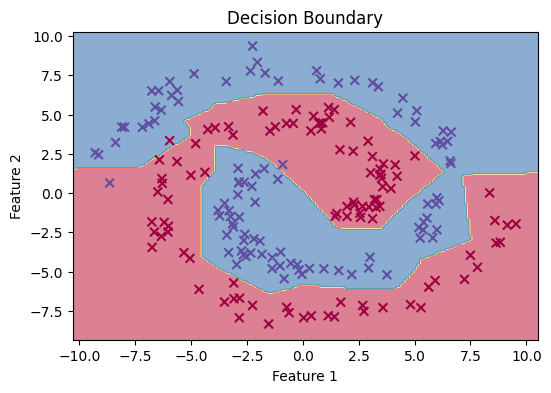

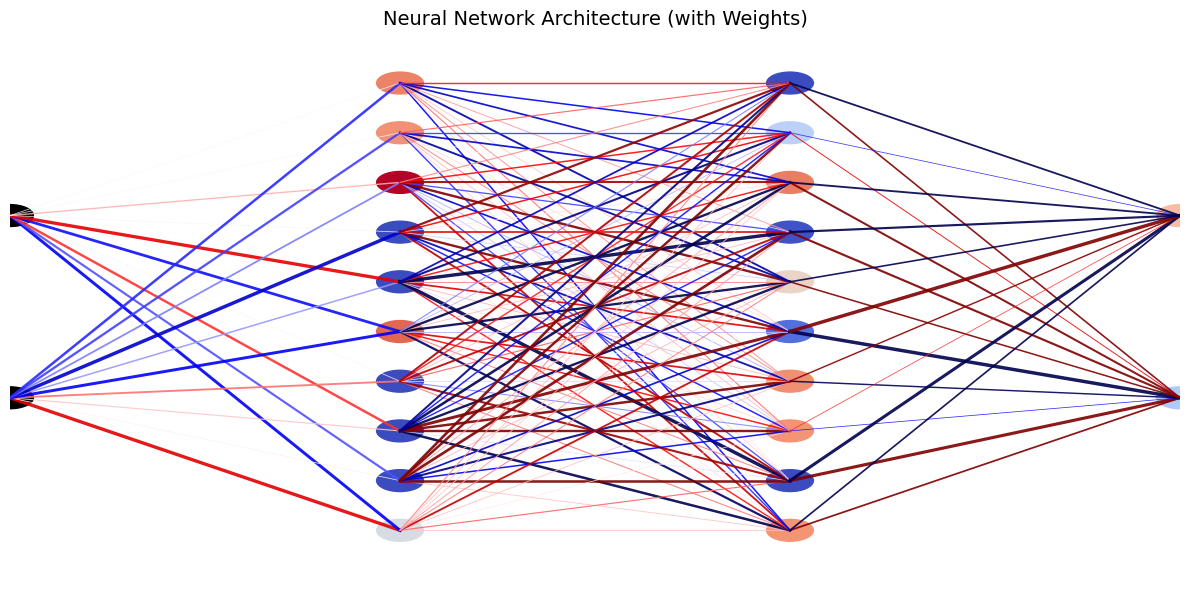

In [107]:
# Example Training
model, history = train_flexible_model(architectures[0], loss_functions[0], dataset)

plot_data_and_decision_boundary(model, X, y)
draw_mlp_network(model, show_weights=True)


Training with Shallow [10]...
Epoch [50/200], Loss: 0.4919, Accuracy: 86.50%
Epoch [100/200], Loss: 0.4166, Accuracy: 92.50%
Epoch [150/200], Loss: 0.4059, Accuracy: 93.00%
Epoch [200/200], Loss: 0.3808, Accuracy: 94.00%
Training for Shallow [10] completed! Final accuracy: 94.00%

Training with Standard [10, 10]...
Epoch [50/200], Loss: 0.3847, Accuracy: 94.00%
Epoch [100/200], Loss: 0.3669, Accuracy: 94.50%
Epoch [150/200], Loss: 0.3772, Accuracy: 94.50%
Epoch [200/200], Loss: 0.3684, Accuracy: 94.00%
Training for Standard [10, 10] completed! Final accuracy: 94.00%

Training with Deep [10, 10, 10]...
Epoch [50/200], Loss: 0.3904, Accuracy: 92.00%
Epoch [100/200], Loss: 0.3944, Accuracy: 91.00%
Epoch [150/200], Loss: 0.3896, Accuracy: 93.00%
Epoch [200/200], Loss: 0.3760, Accuracy: 93.00%
Training for Deep [10, 10, 10] completed! Final accuracy: 93.00%

Training with Wide [20, 20]...
Epoch [50/200], Loss: 0.3819, Accuracy: 94.50%
Epoch [100/200], Loss: 0.3644, Accuracy: 94.50%
Epoch [

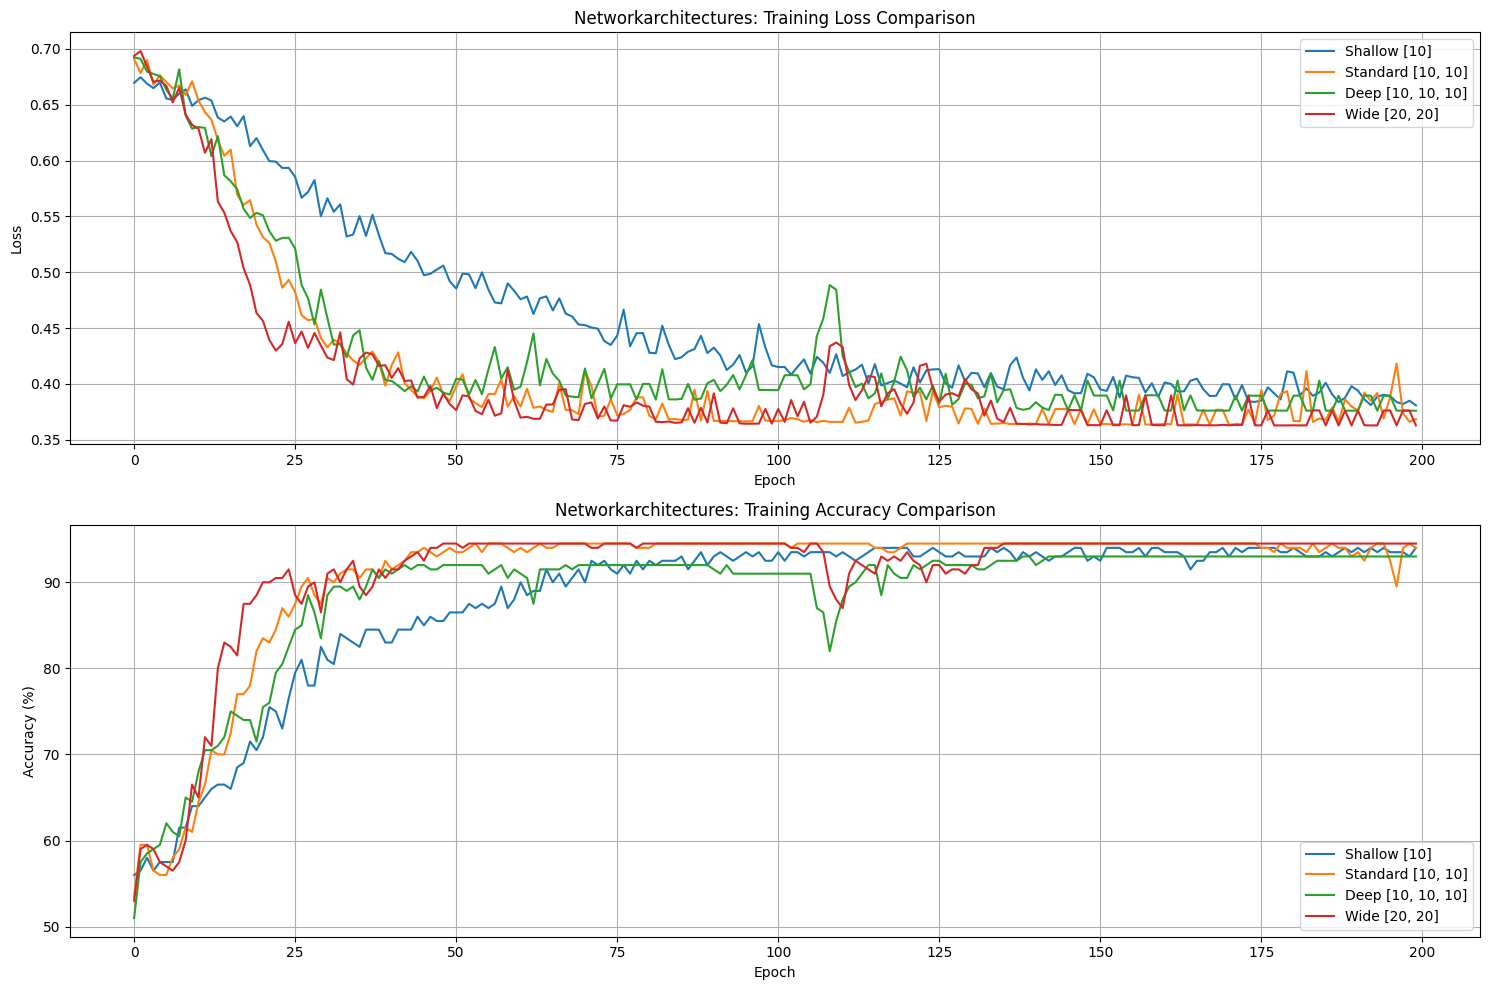

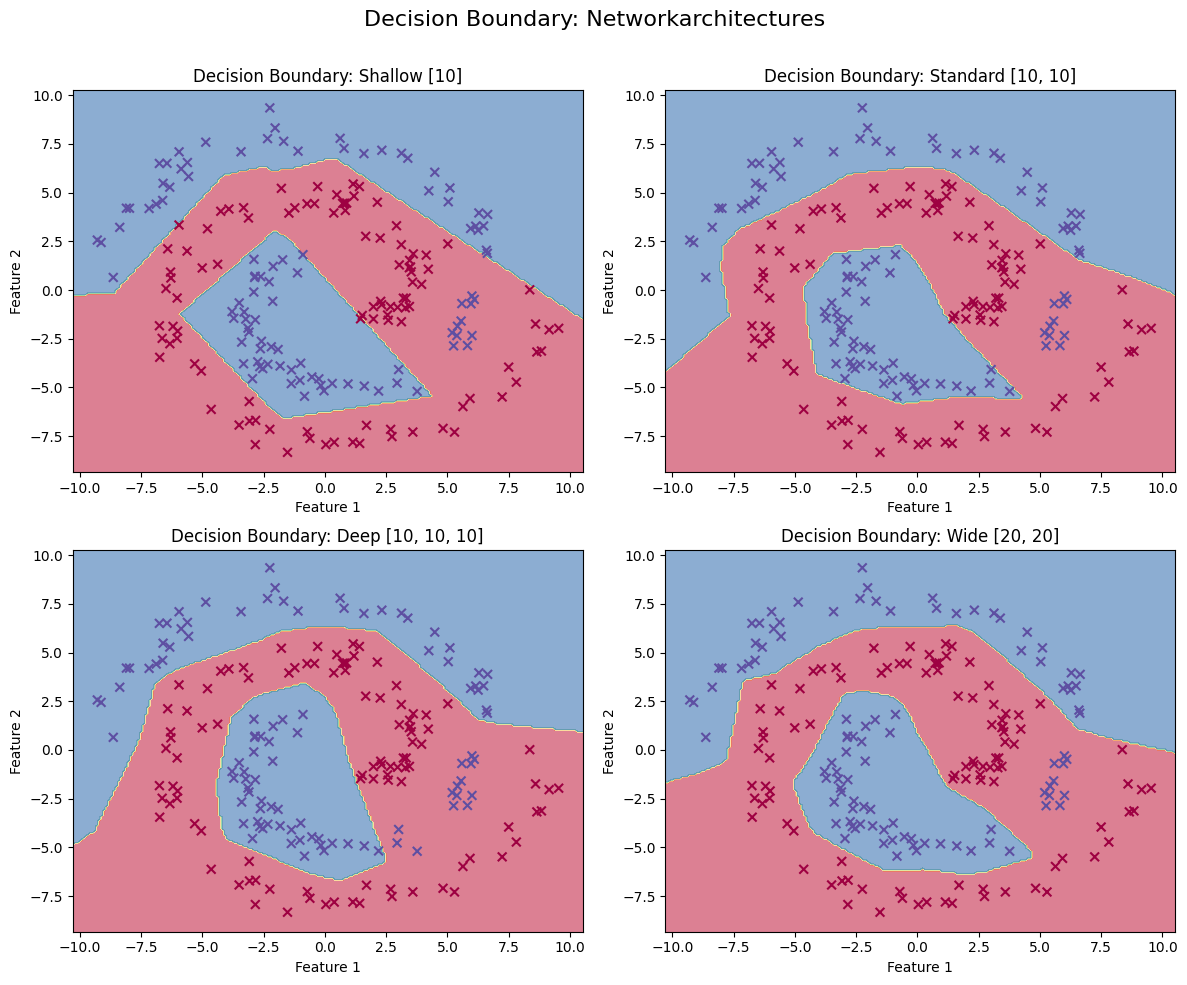

In [108]:
arch_results = compare_parameter_group(architectures, dataset)
visualize_results(arch_results, X, y,"Networkarchitectures")


Training with ReLU...
Epoch [50/200], Loss: 0.3560, Accuracy: 97.00%
Epoch [100/200], Loss: 0.3263, Accuracy: 99.00%
Epoch [150/200], Loss: 0.3193, Accuracy: 99.50%
Epoch [200/200], Loss: 0.3185, Accuracy: 99.50%
Training for ReLU completed! Final accuracy: 99.50%

Training with Sigmoid...
Epoch [50/200], Loss: 0.5776, Accuracy: 80.50%
Epoch [100/200], Loss: 0.5127, Accuracy: 84.50%
Epoch [150/200], Loss: 0.4704, Accuracy: 84.00%
Epoch [200/200], Loss: 0.4938, Accuracy: 85.50%
Training for Sigmoid completed! Final accuracy: 85.50%

Training with Tanh...
Epoch [50/200], Loss: 0.4827, Accuracy: 83.50%
Epoch [100/200], Loss: 0.4566, Accuracy: 86.00%
Epoch [150/200], Loss: 0.4585, Accuracy: 86.00%
Epoch [200/200], Loss: 0.4989, Accuracy: 82.50%
Training for Tanh completed! Final accuracy: 82.50%

Training with LeakyReLU...
Epoch [50/200], Loss: 0.4242, Accuracy: 90.50%
Epoch [100/200], Loss: 0.3961, Accuracy: 93.00%
Epoch [150/200], Loss: 0.4233, Accuracy: 91.50%
Epoch [200/200], Loss: 0.

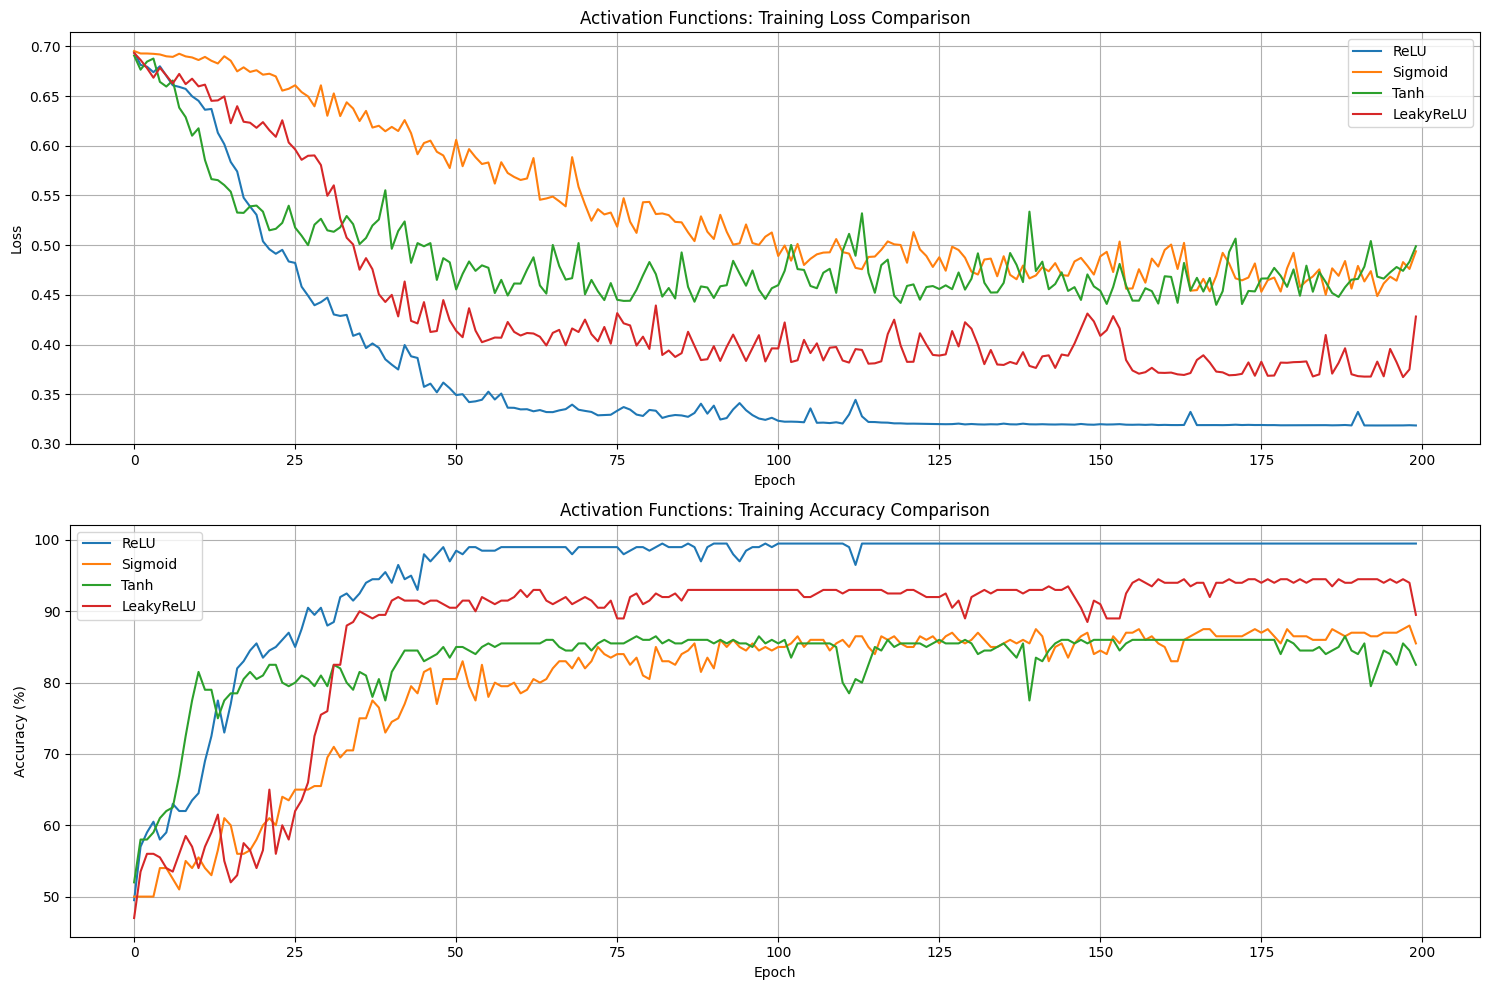

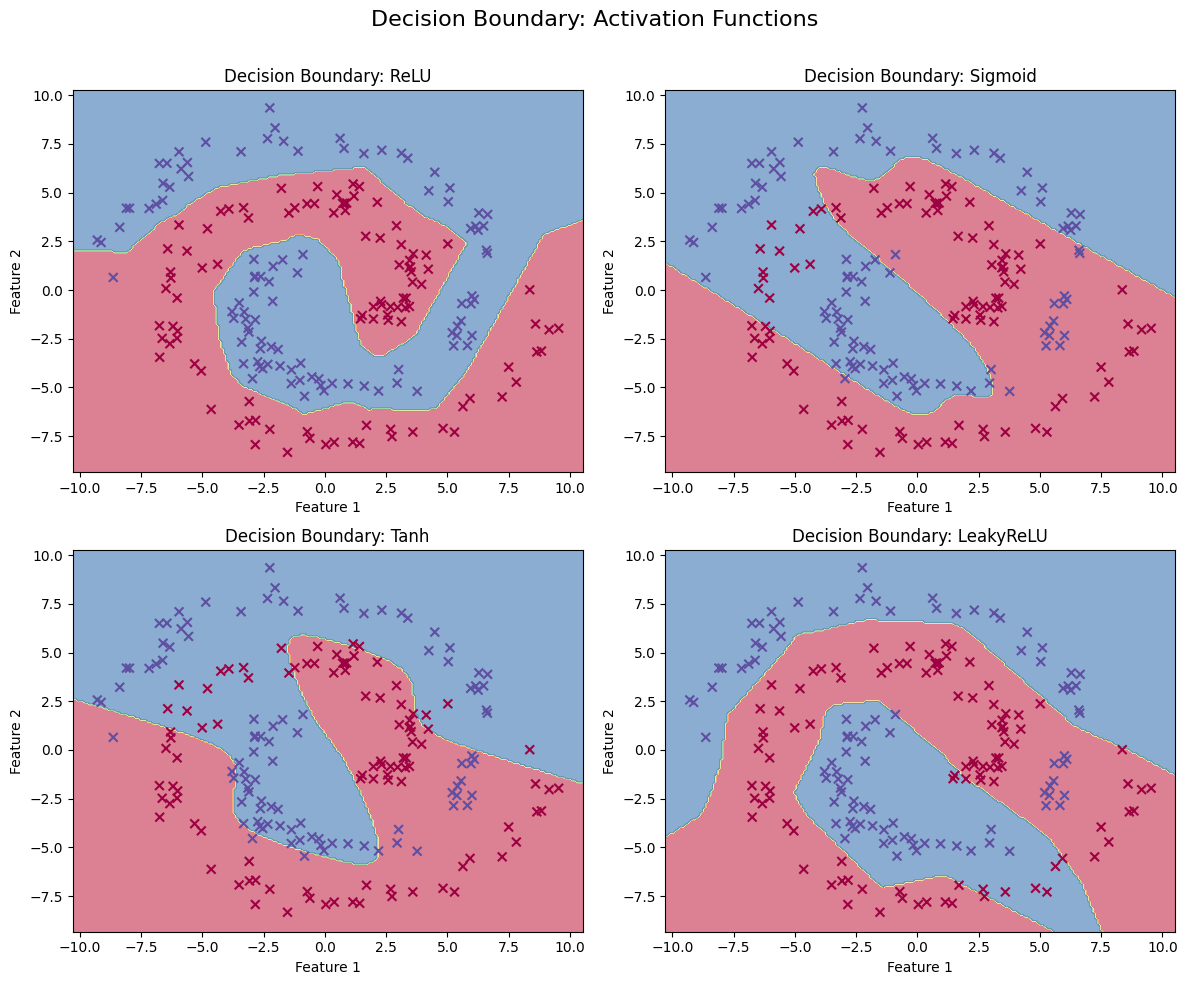

In [109]:
act_results = compare_parameter_group(activation_functions, dataset)
visualize_results(act_results,X,y, "Activation Functions")


Training with Adam LR=0.01...
Epoch [50/200], Loss: 0.4043, Accuracy: 93.50%
Epoch [100/200], Loss: 0.3864, Accuracy: 94.50%
Epoch [150/200], Loss: 0.3802, Accuracy: 94.50%
Epoch [200/200], Loss: 0.3738, Accuracy: 93.50%
Training for Adam LR=0.01 completed! Final accuracy: 93.50%

Training with SGD LR=0.01...
Epoch [50/200], Loss: 0.6921, Accuracy: 55.00%
Epoch [100/200], Loss: 0.6898, Accuracy: 58.50%
Epoch [150/200], Loss: 0.6859, Accuracy: 59.00%
Epoch [200/200], Loss: 0.6820, Accuracy: 58.00%
Training for SGD LR=0.01 completed! Final accuracy: 58.00%

Training with RMSprop LR=0.01...
Epoch [50/200], Loss: 0.5351, Accuracy: 79.50%
Epoch [100/200], Loss: 0.4565, Accuracy: 84.50%
Epoch [150/200], Loss: 0.4652, Accuracy: 85.00%
Epoch [200/200], Loss: 0.4562, Accuracy: 84.00%
Training for RMSprop LR=0.01 completed! Final accuracy: 84.00%

Training with Adam LR=0.001...
Epoch [50/200], Loss: 0.6574, Accuracy: 61.50%
Epoch [100/200], Loss: 0.6539, Accuracy: 63.00%
Epoch [150/200], Loss: 

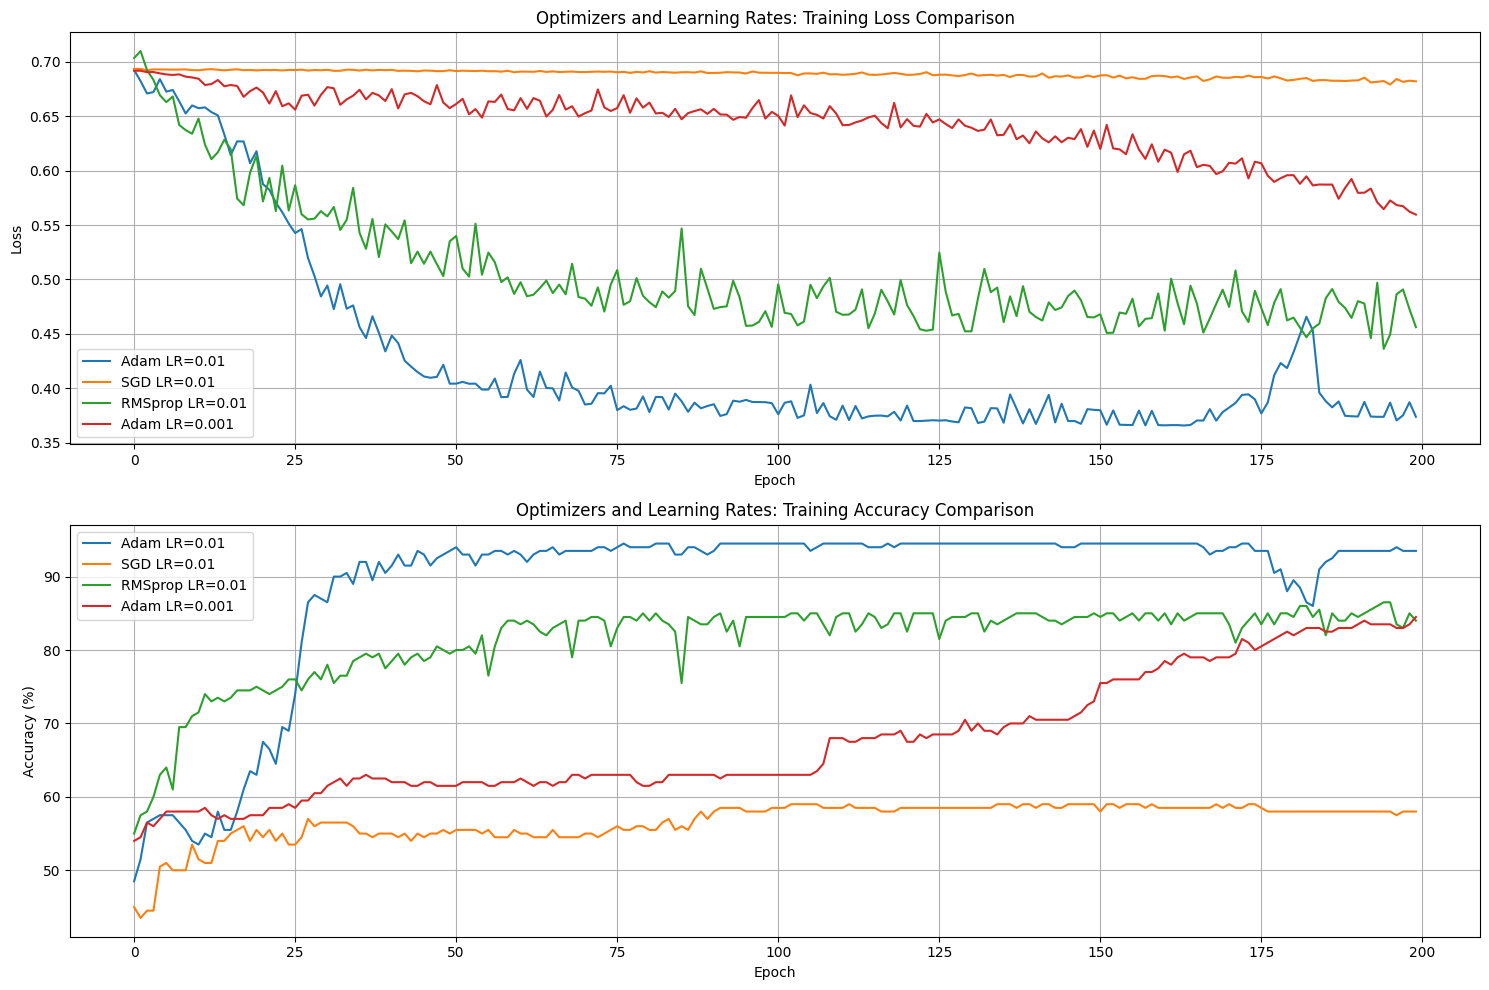

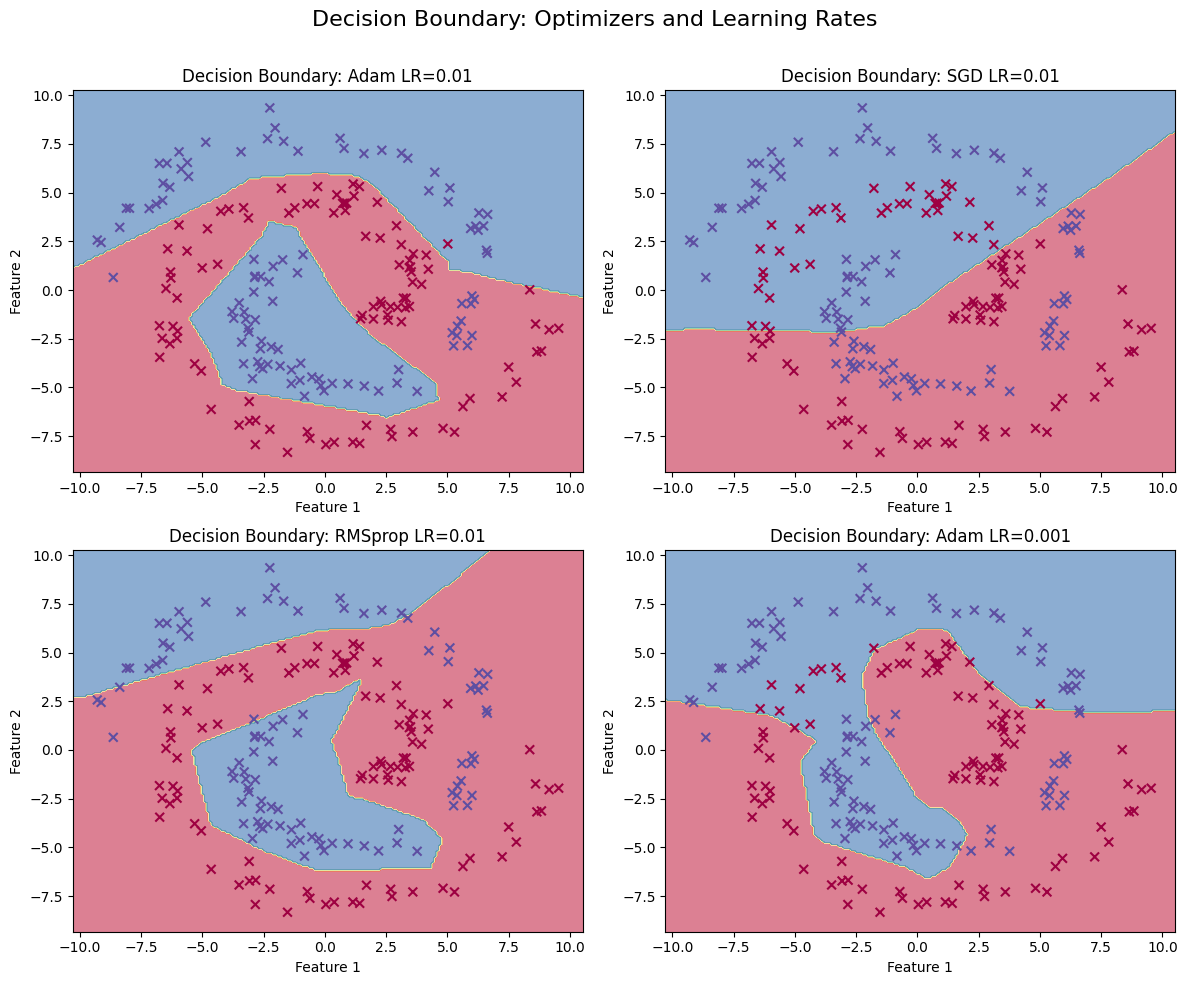

In [110]:
optimizer_results = compare_parameter_group(optimizers, dataset)
visualize_results(optimizer_results,X,y, "Optimizers and Learning Rates")


Training with CrossEntropy...
Epoch [50/200], Loss: 0.4333, Accuracy: 90.00%
Epoch [100/200], Loss: 0.3876, Accuracy: 92.50%
Epoch [150/200], Loss: 0.3844, Accuracy: 94.50%
Epoch [200/200], Loss: 0.3658, Accuracy: 94.50%
Training for CrossEntropy completed! Final accuracy: 94.50%

Training with MSE...
Epoch [50/200], Loss: 0.0832, Accuracy: 90.00%
Epoch [100/200], Loss: 0.0432, Accuracy: 94.50%
Epoch [150/200], Loss: 0.0335, Accuracy: 94.00%
Epoch [200/200], Loss: 0.0026, Accuracy: 100.00%
Training for MSE completed! Final accuracy: 100.00%


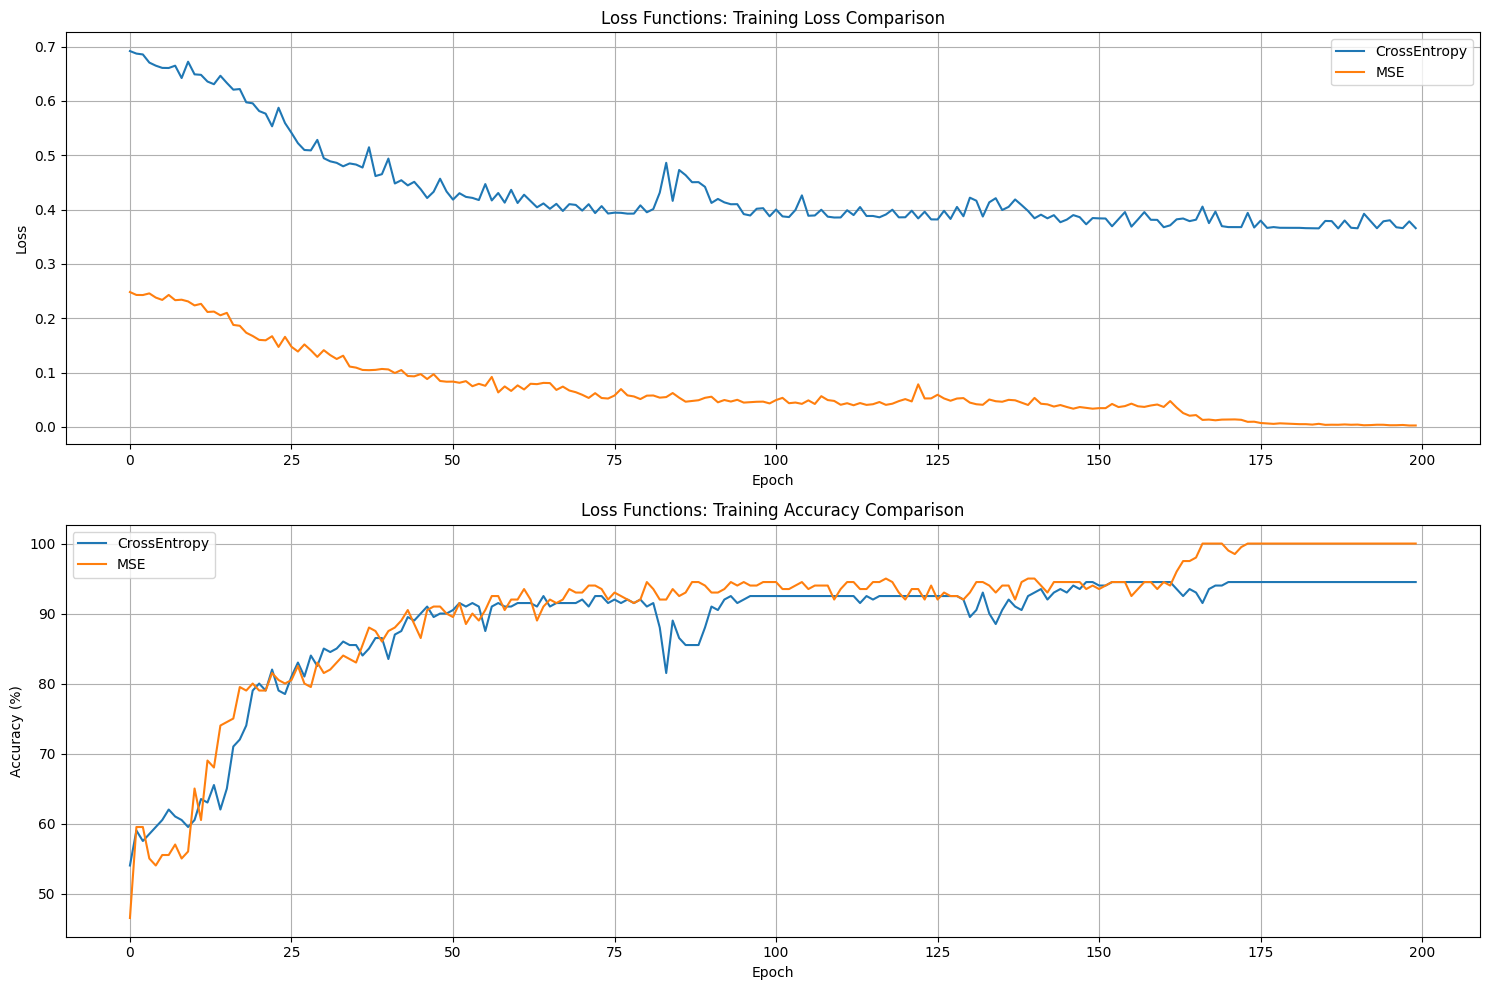

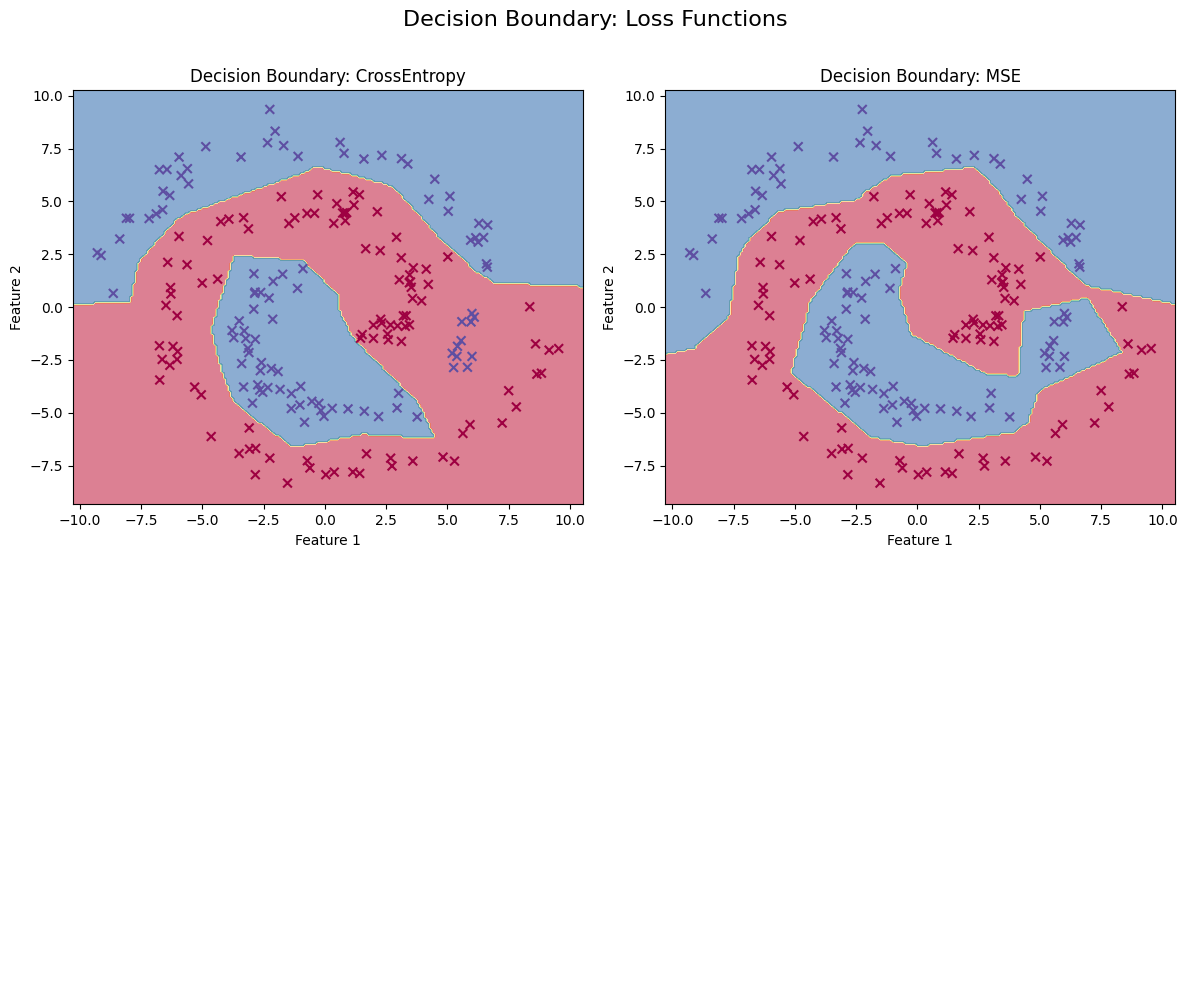

In [111]:
loss_results = compare_parameter_group(loss_functions, dataset)
visualize_results(loss_results,X,y, "Loss Functions")


Training with Batch Size=8...
Epoch [50/200], Loss: 0.3794, Accuracy: 94.00%
Epoch [100/200], Loss: 0.3819, Accuracy: 93.50%
Epoch [150/200], Loss: 0.3686, Accuracy: 94.50%
Epoch [200/200], Loss: 0.3684, Accuracy: 94.50%
Training for Batch Size=8 completed! Final accuracy: 94.50%

Training with Batch Size=32...
Epoch [50/200], Loss: 0.4122, Accuracy: 91.50%
Epoch [100/200], Loss: 0.3842, Accuracy: 93.00%
Epoch [150/200], Loss: 0.4034, Accuracy: 93.00%
Epoch [200/200], Loss: 0.3683, Accuracy: 94.00%
Training for Batch Size=32 completed! Final accuracy: 94.00%

Training with Batch Size=64...
Epoch [50/200], Loss: 0.4677, Accuracy: 88.00%
Epoch [100/200], Loss: 0.3828, Accuracy: 92.00%
Epoch [150/200], Loss: 0.3983, Accuracy: 93.00%
Epoch [200/200], Loss: 0.3696, Accuracy: 93.00%
Training for Batch Size=64 completed! Final accuracy: 93.00%

Training with Full Batch...
Epoch [50/200], Loss: 0.5760, Accuracy: 79.50%
Epoch [100/200], Loss: 0.4342, Accuracy: 89.50%
Epoch [150/200], Loss: 0.4

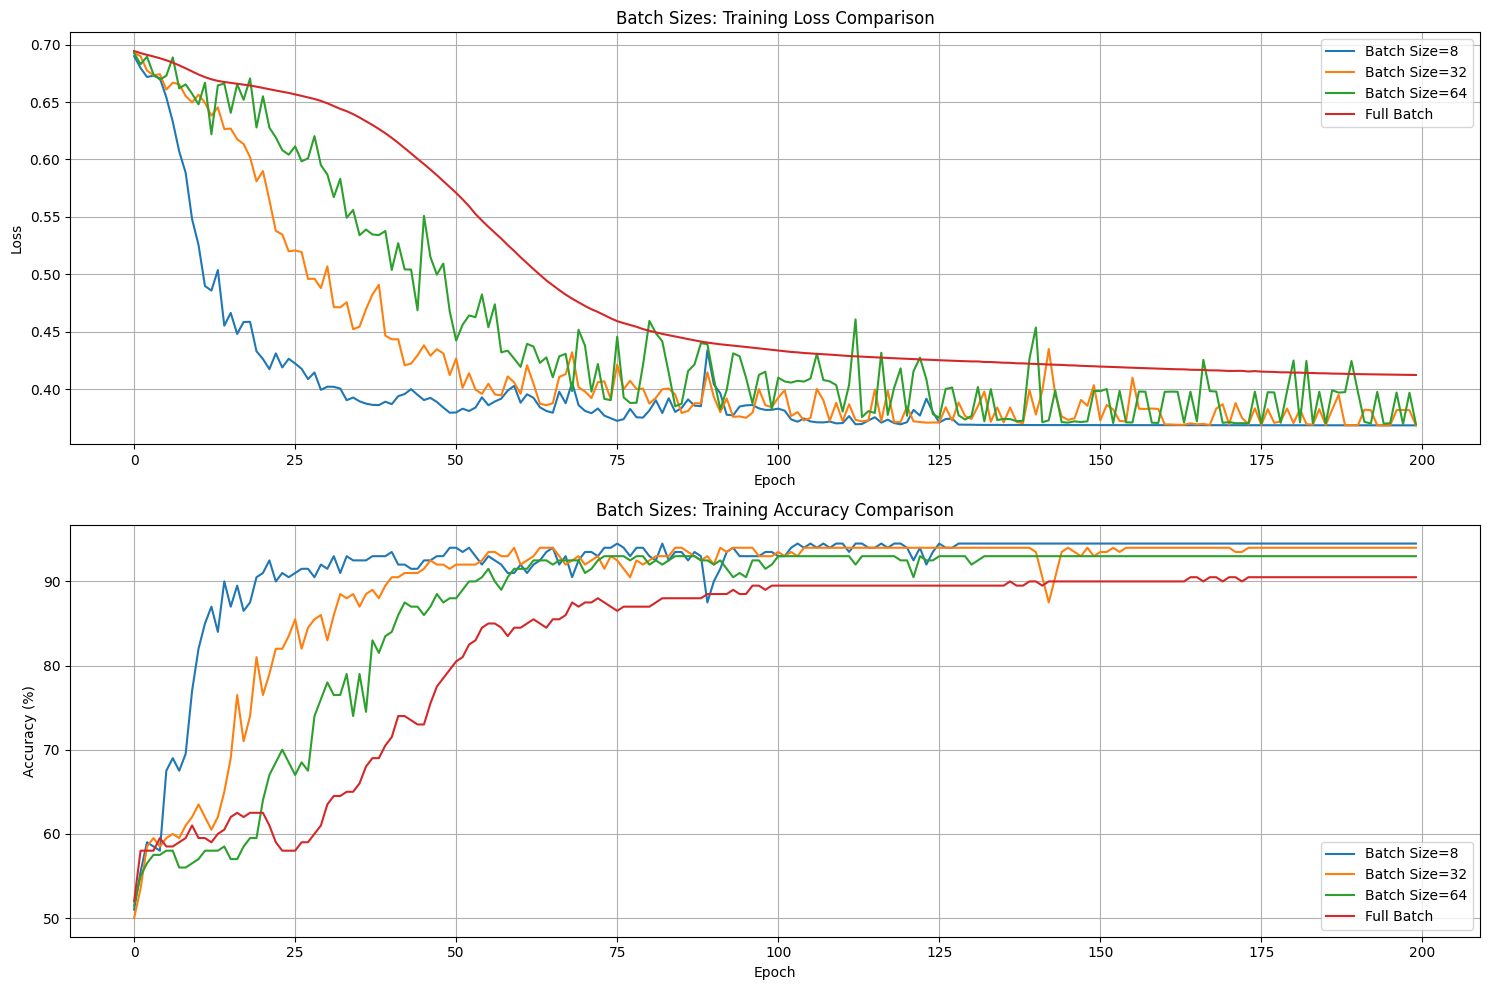

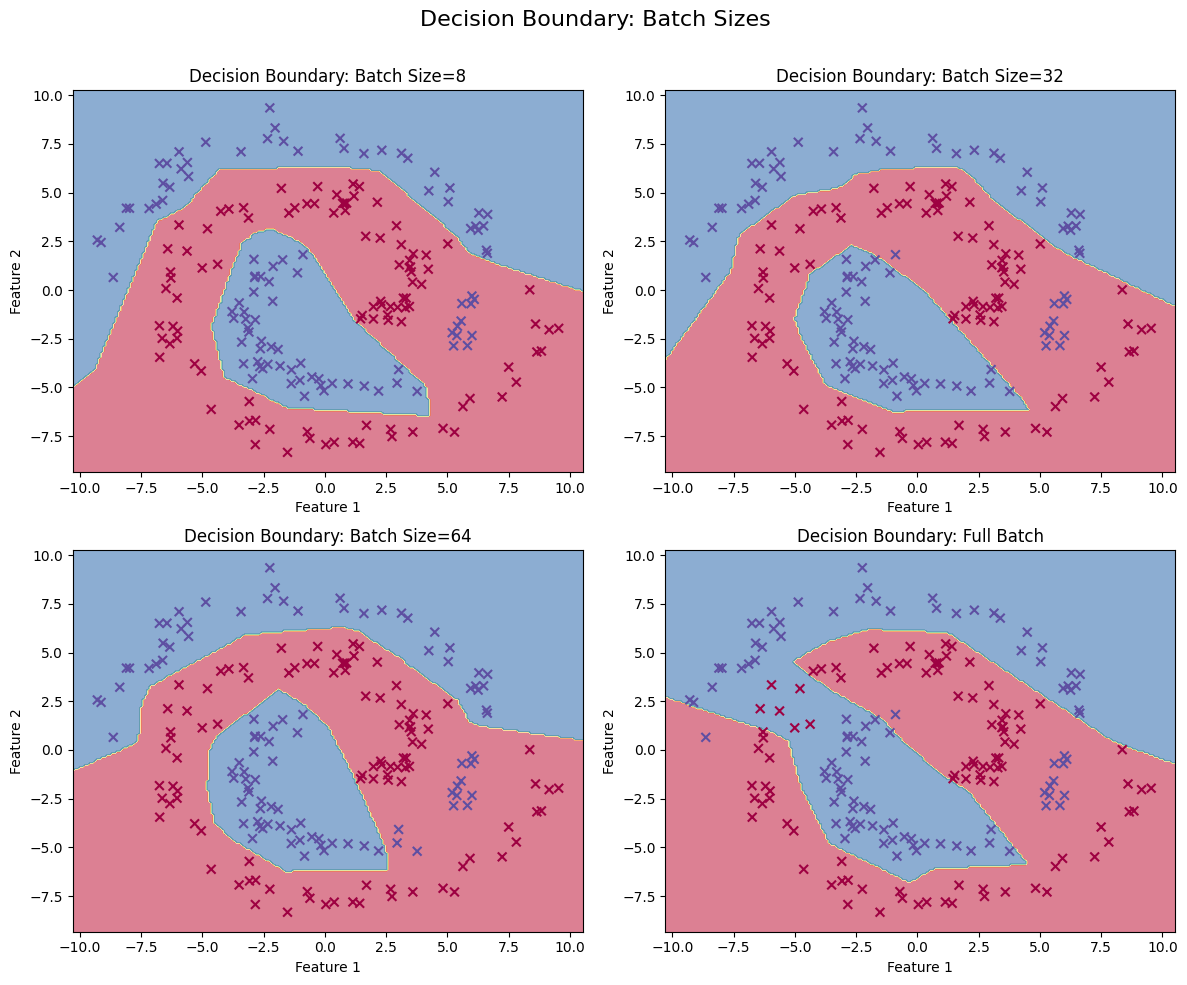

In [112]:
batch_results = compare_parameter_group(batch_sizes, dataset)
visualize_results(batch_results,X,y, "Batch Sizes")

# **Q3 - its your turn now**

In [ ]:
# Create your own parameter combinations
custom_params = [
    {
        'name': 'Perfect Model',
        'model_params': {
            'input_dim': 2,
            'hidden_layers': [10, 10],  
            'output_dim': 2,
            'activation': nn.ReLU()
        },
        'training_params': {
            'loss_fn': nn.MSELoss,
            'optimizer_fn': optim.Adam,
            'learning_rate': 0.01,     
            'batch_size': 64,           
            'num_epochs': 200          
        }
    },
    {
        'name': 'Custom Model',
        'model_params': {
            'input_dim': 2,
            'hidden_layers': [20, 10, 5,10,15,5],  
            'output_dim': 2,
            'activation': nn.Sigmoid()  
        },
        'training_params': {
            'loss_fn': nn.CrossEntropyLoss,
            'optimizer_fn': optim.RMSprop,
            'learning_rate': 0.002,
            'batch_size': 32,
            'num_epochs': 2000
        }
    }
]


Training with perfect model...
Epoch [50/200], Loss: 0.0788, Accuracy: 88.50%
Epoch [100/200], Loss: 0.0271, Accuracy: 97.00%
Epoch [150/200], Loss: 0.0078, Accuracy: 99.50%
Epoch [200/200], Loss: 0.0057, Accuracy: 99.50%
Training for perfect model completed!

Training with Custom Modell...
Epoch [50/2000], Loss: 0.6928, Accuracy: 50.00%
Epoch [100/2000], Loss: 0.6932, Accuracy: 50.00%
Epoch [150/2000], Loss: 0.6902, Accuracy: 63.00%
Epoch [200/2000], Loss: 0.6623, Accuracy: 63.00%
Epoch [250/2000], Loss: 0.6597, Accuracy: 63.50%
Epoch [300/2000], Loss: 0.6533, Accuracy: 63.50%
Epoch [350/2000], Loss: 0.6800, Accuracy: 63.50%
Epoch [400/2000], Loss: 0.6518, Accuracy: 63.50%
Epoch [450/2000], Loss: 0.6654, Accuracy: 63.50%
Epoch [500/2000], Loss: 0.6720, Accuracy: 63.50%
Epoch [550/2000], Loss: 0.6668, Accuracy: 63.50%
Epoch [600/2000], Loss: 0.6796, Accuracy: 63.50%
Epoch [650/2000], Loss: 0.6495, Accuracy: 63.50%
Epoch [700/2000], Loss: 0.6654, Accuracy: 63.50%
Epoch [750/2000], Loss

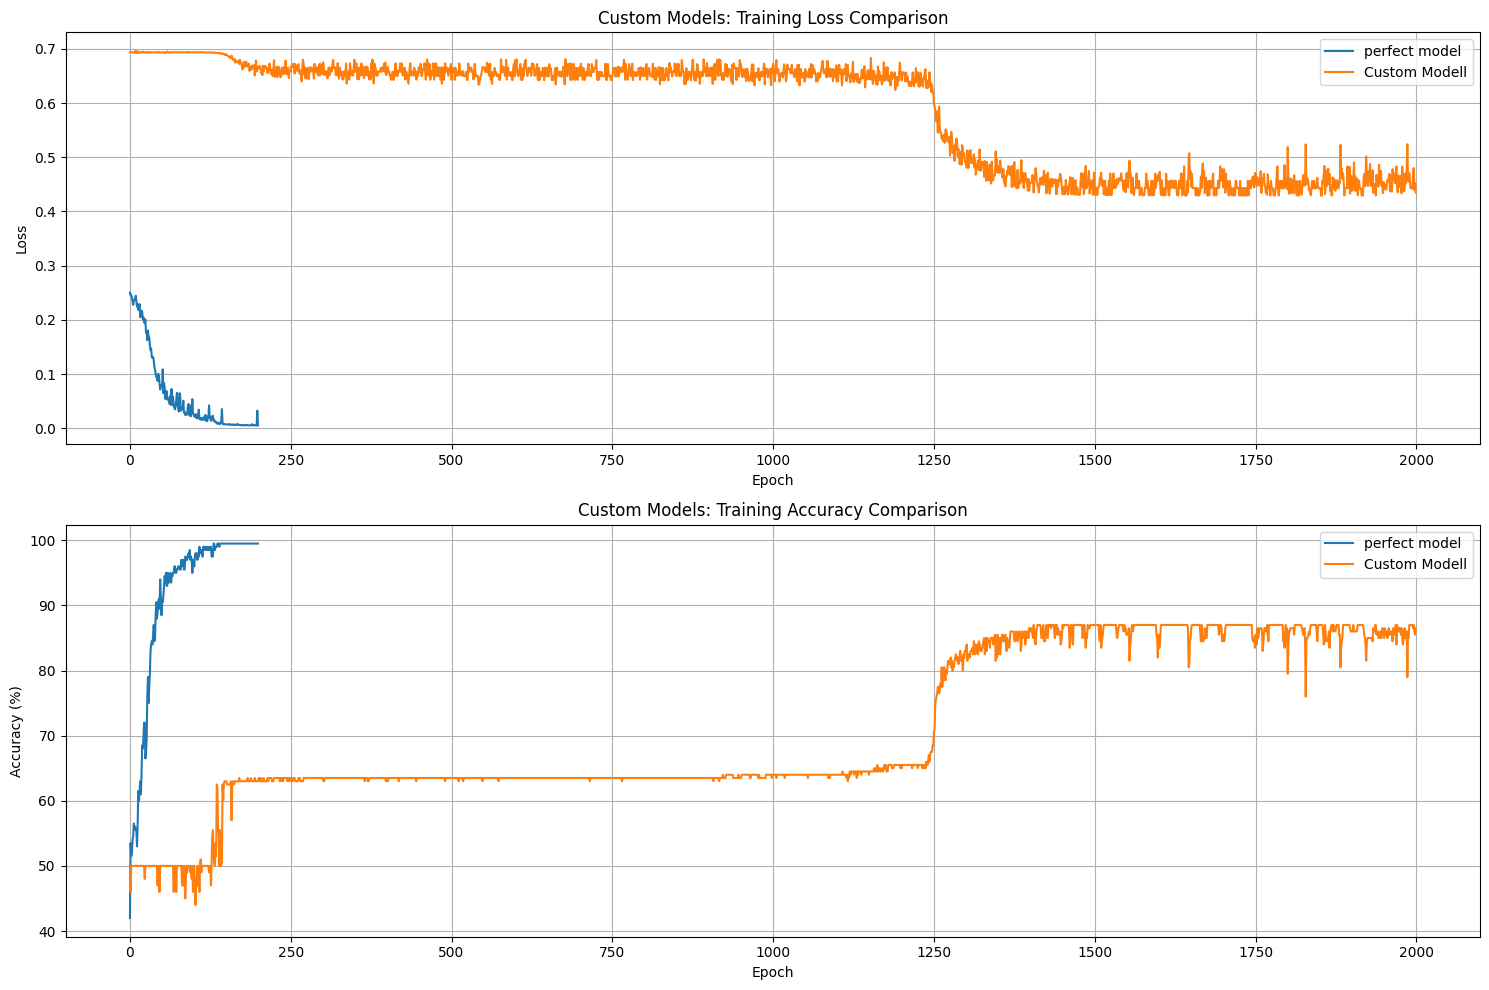

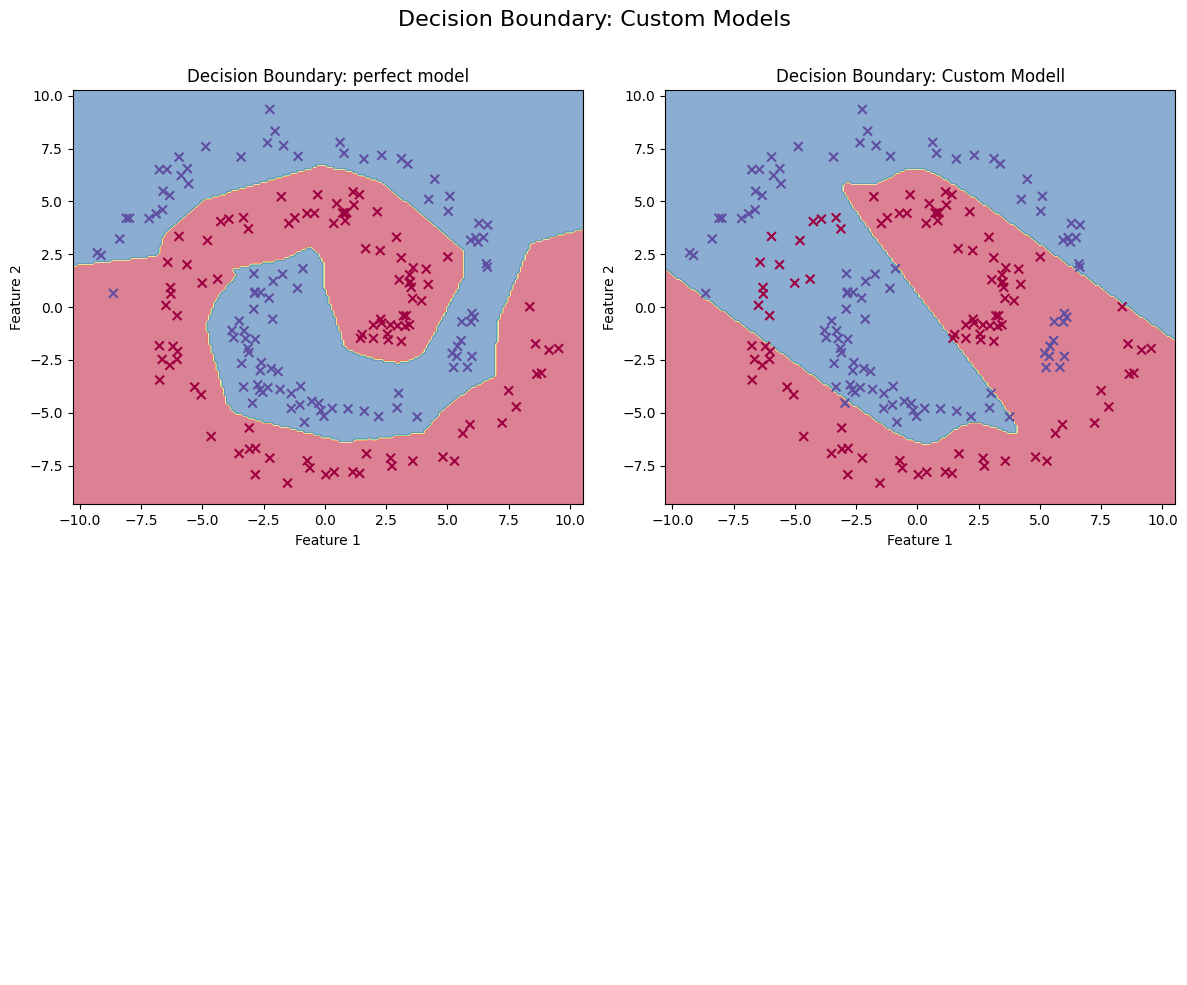

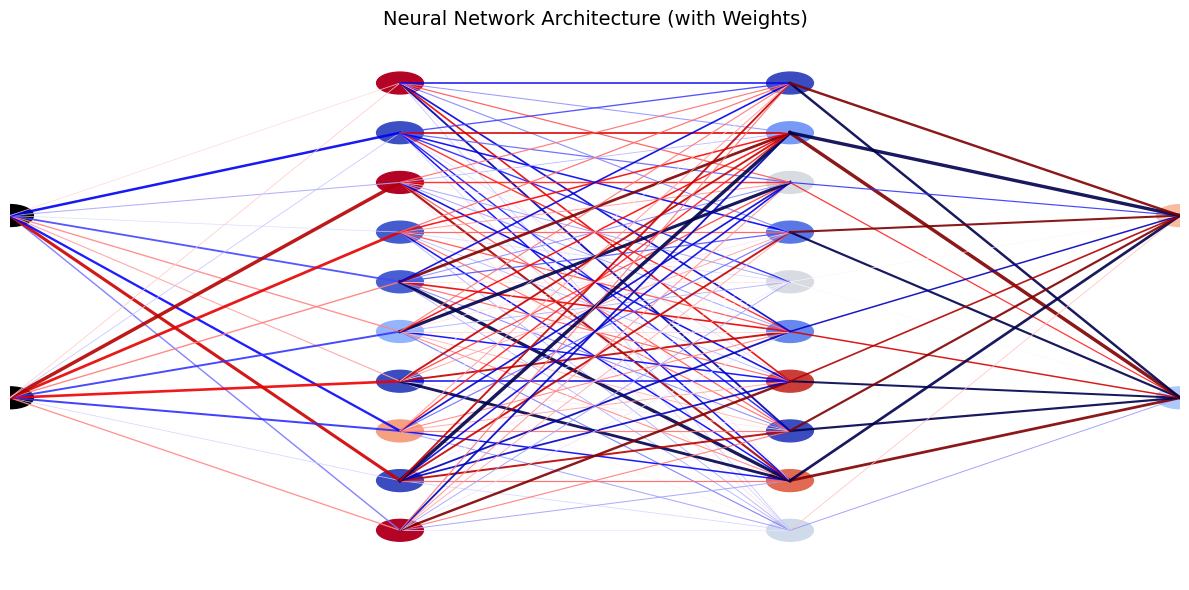

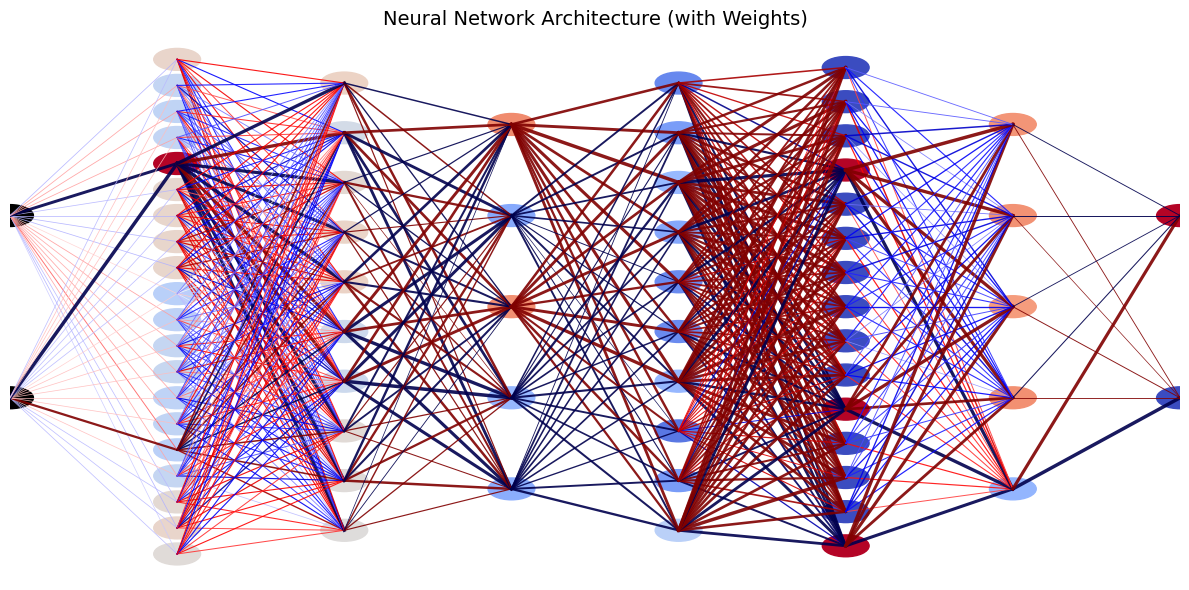

In [114]:
custom_results = []
for param_set in custom_params:
    print(f"\nTraining with {param_set['name']}...")
    model, history = train_flexible_model(
        param_set.get('model_params', {}),
        param_set.get('training_params', {}),
        dataset
    )
    custom_results.append({
        'params': param_set,
        'model': model,
        'history': history
    })
    print(f"Training for {param_set['name']} completed!")

visualize_results(custom_results, X, y, "Custom Models")
draw_mlp_network(
    custom_results[0]['model'],
    #architecture_dict=custom_params[0]['model_params'],
    show_weights=True
)
draw_mlp_network(
    custom_results[1]['model'],
    #architecture_dict=custom_params[1]['model_params'],
    show_weights=True
)